## Libraries

In [1]:
!pip install miseval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 26.5 MB/s eta 0:00:0000:01:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 41.9 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 26.5 MB/s eta 0:00:0000:0100:01
  Created wheel for dictances: filename=dictances-1.5.6-py3-none-any.whl size=13517 sha256=84c486b875e1c8aecb367c2913af2af8c73d10da8f50fe4171d52d5d50795d80
  Stored in directory: /root/.cache/pip/wheels/cc/96/4d/91f2edcb5d2584367af01e025c786759fffe618127f10eadbd
  Created wheel for hausdorff: filename=hausdorff-0.2.6-py3-none-any.whl size=15187 sha256=dd1e9cb48a064a27ac3741c4d8e4f337cdf0dc0cda09dacbfb5af9d0c8338052
  Stored in directory: /root/.cache/pip/wheels/8d/56/ea/fd4bbacf1217e197e63de821a74730e953b23fdf2030733061

In [2]:
#Standard imports
import os
import math
import pathlib
import shutil
import matplotlib.pyplot as plt
import cv2
import numpy as np
from scipy.ndimage import rotate
import re
import random
#import segmentation_models as sm
#import segmentation_models_pytorch as sm
import time
from sklearn.model_selection import train_test_split
from miseval import evaluate
from tqdm import tqdm
from PIL import Image
#Tensorflow imports
#import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers
#from tensorflow.keras.utils import image_dataset_from_directory, img_to_array, load_img, array_to_img, save_img, to_categorical



In [3]:
#PyTorch imports
import torch
from torch.nn import functional as f
from torch.utils.data import TensorDataset, Dataset
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.transforms import functional as F
from torchvision import transforms
from torch import nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data Pipeline

![](Data_Pipeline.png)

In [14]:
class MultiClassSegmentationDataset(Dataset):
    
    def __init__(self, image_files, mask_dirs, size, classes,n_classes, background=True, test_mode=False):
        
        assert len(image_files) == len(mask_dirs)
        
        self.image_files = sorted(image_files)
        self.mask_dirs = sorted(mask_dirs)
        self.annotation_files = {}
        
        for img_fldr in self.mask_dirs:
            self.annotation_files[img_fldr] = sorted(os.listdir(img_fldr))
            
        self.H = size
        self.W = size
        self.n = n_classes
        self.classes = dict(zip(sorted(classes), range(n_classes)))
        self.background = background
        self.test_mode = test_mode

    
    def __len__(self):
        
        return len(self.image_files)

    def __getitem__(self, idx):
        
        #Reading the image
        img_path = self.image_files[idx]

        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.H,self.W))
        #norm_img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        norm_img = img / 255.0
        norm_img = np.transpose(norm_img, (2, 0, 1))
        img_tensor = torch.from_numpy(norm_img)
        img_tensor = img_tensor.float()
        
        
        #Preparing mask - There are 4 lesion classes, the directories have 1 picture each for a specific lesion, have to combine them
        #1 extra class for the background
        #The background mask is currently all ones, the ones from each class have to be subtracted from it
        background = np.ones((self.H, self.W))
        mask = np.zeros((self.n + 1, self.H, self.W))
        ann_fldr = self.mask_dirs[idx]
        ann_files = self.annotation_files[ann_fldr]
        for ann_file in ann_files:

            code = ann_file[:-4]
            ix = self.classes[code]
            ann_path = os.path.join(ann_fldr, ann_file)
            ann = cv2.imread(ann_path, 0)
            ann = cv2.resize(ann, (self.H, self.W), cv2.INTER_NEAREST)
            #update background by subtracting the current pixel positions
            background = background - ann
            
            ann = np.expand_dims(ann, axis=0)
            
            mask[ix+1, :, :] = ann
        
        #If there are overlapping pixel values, the pixel value at a certain position may be negative, have to clip to 0
        background = np.clip(background, 0, None)
        background = np.expand_dims(background, axis=0)
        #Place the background class inside
        if self.background:
            mask[0,:,:] = background
        
        mask_tensor = torch.from_numpy(mask)
        mask_tensor = mask_tensor.float()
        
        if not self.test_mode:
            #Data augmentation if it's not test_mode, for example training and validation data will get augmented
            augment_mode = np.random.randint(0,4)
            if augment_mode == 0:
                img_tensor = F.hflip(img_tensor)
                mask_tensor = F.hflip(mask_tensor)
            elif augment_mode == 1:
                img_tensor = F.vflip(img_tensor)
                mask_tensor = F.vflip(mask_tensor)
            elif augment_mode == 2:
                angle = np.random.randint(-5, 5)
                img_tensor = F.rotate(img_tensor, angle)
                mask_tensor = F.rotate(mask_tensor, angle)

            
        return img_tensor, mask_tensor
        
        
                
        
        

        

## Models and U-Nets

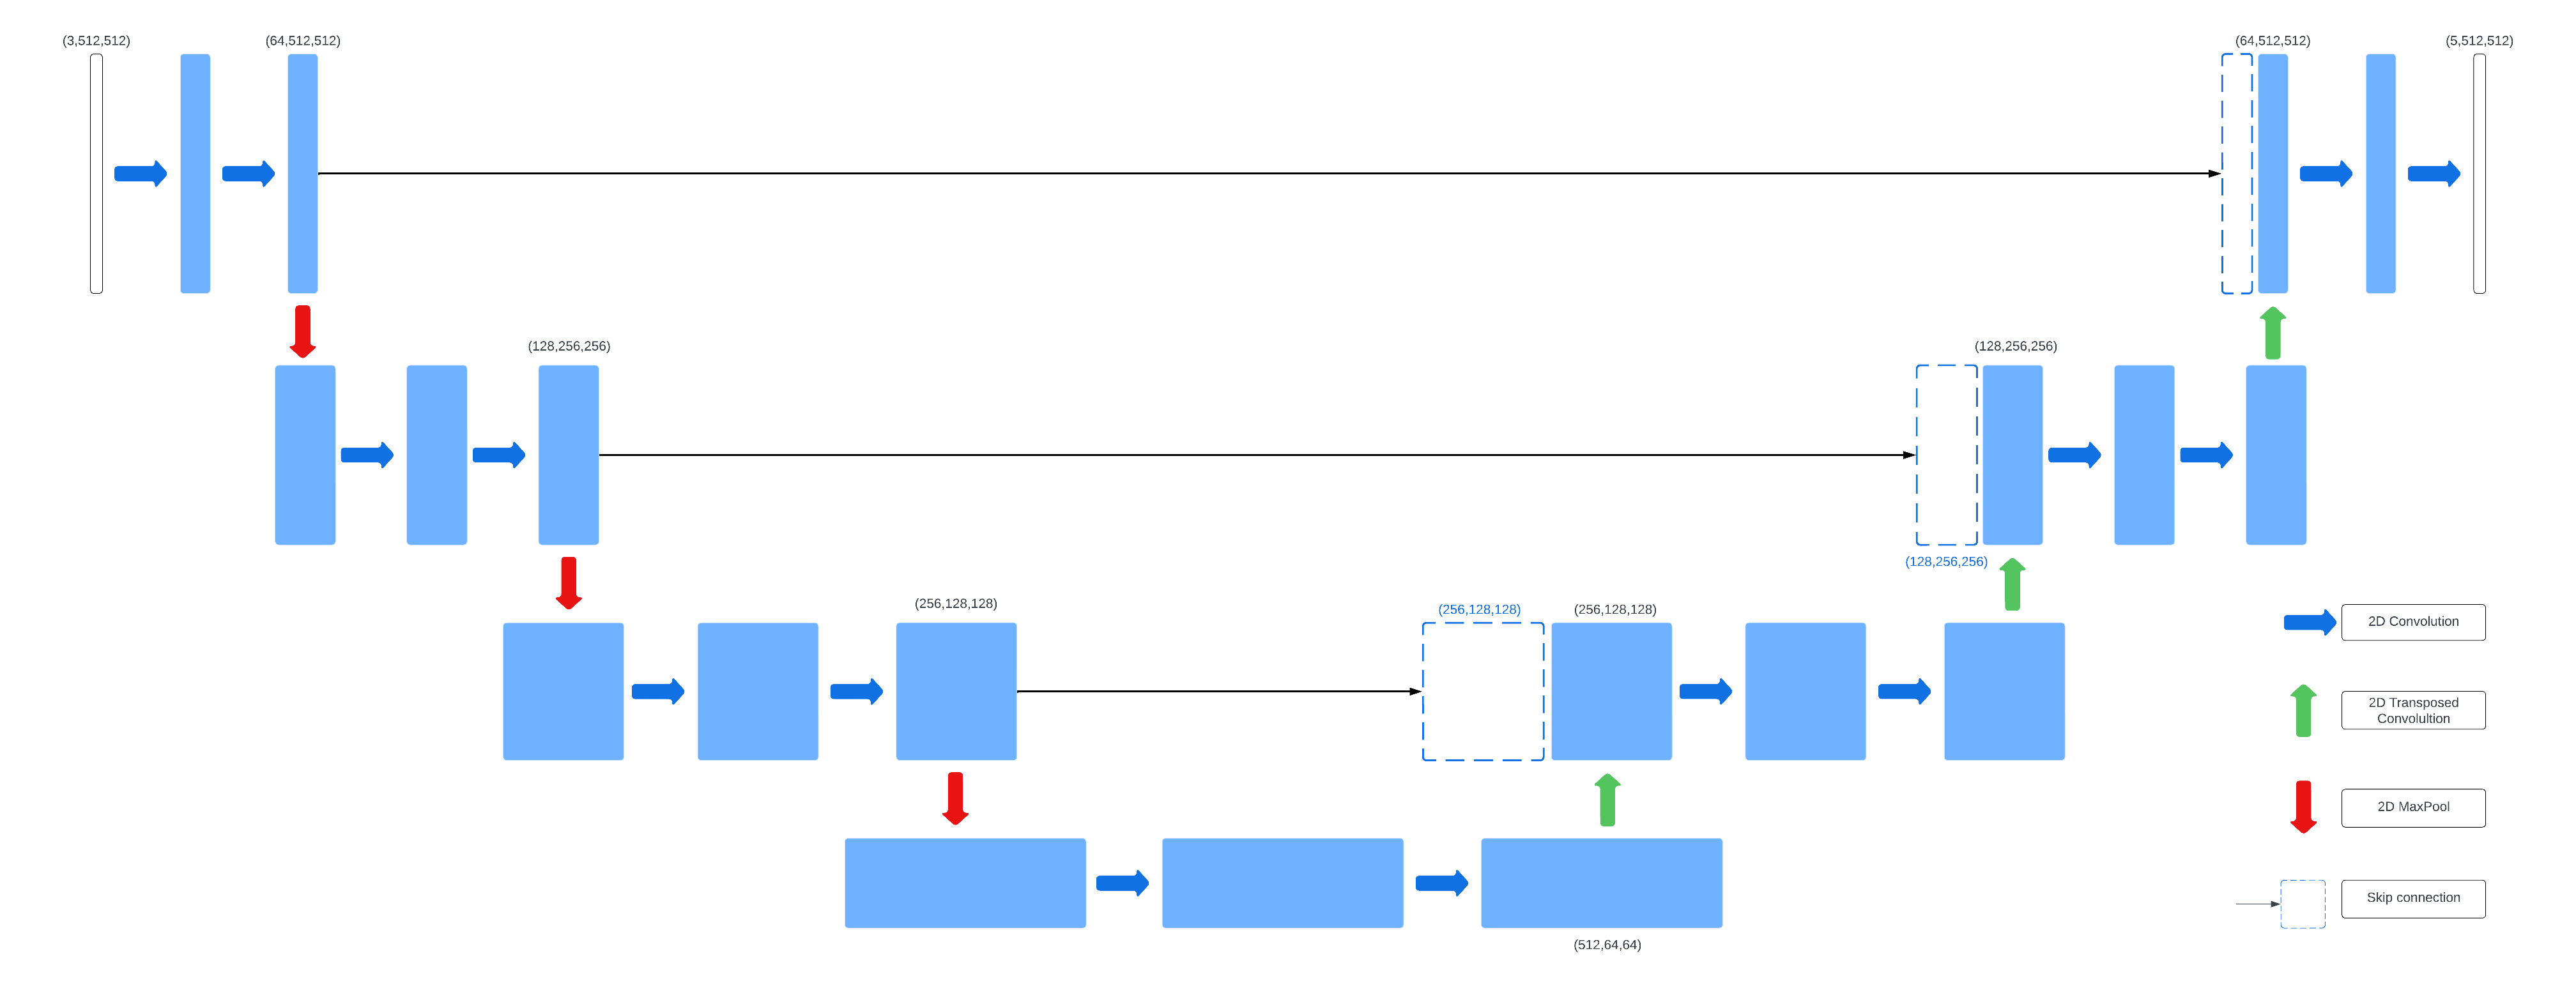

### Base Model

In [15]:
class BaseModel():

    def predict(self, dataloader):
        """This function """
        self.eval()

        with torch.no_grad():
            
            predictions = []
            for images, _ in tqdm(dataloader):
                images = images.to(device)
                outputs = self(images)
                outputs = torch.nn.functional.softmax(outputs, dim=1)
                predictions.append(outputs.permute(0, 2, 3, 1))
            predictions = torch.cat(predictions, dim=0)
        
        return predictions.detach().cpu().numpy()
    
    def predict_image(self, image):
        """This function returns the prediction of one image"""
        self.eval()
        with torch.no_grad():
            
            image = image.unsqueeze(0)
            image = image.to(device)
            output = self(image)
            output = torch.nn.functional.softmax(output, dim=1)
            output = output.detach().cpu().numpy()
            output = np.transpose(output, (0, 2, 3, 1))
            return output

### Decoder

In [18]:
class SimpleDecoderBlock(nn.Module):

    def __init__(self, d_in, d_out):

        super().__init__()

        self.upconv = nn.UpsamplingBilinear2d(scale_factor=2)
        self.conv_1 = nn.Conv2d(d_in, d_out, 1, 1)
        self.relu = nn.ReLU()
        self.conv_2 = nn.Conv2d(d_out*2, d_out, 3, 1, "same")
        self.bn1 = nn.BatchNorm2d(d_out)
        self.conv_3 = nn.Conv2d(d_out, d_out, 3, 1, "same")
        self.bn2 = nn.BatchNorm2d(d_out)

    def forward(self, inp, a):

        x = self.upconv(inp)
        x = self.relu(self.conv_1(x))

        if a is not None:

            x = torch.cat([a, x], axis=1)
            x = self.conv_2(x)
            x = self.bn1(x)
            x = self.relu(x)
            
        x = self.conv_3(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x


        

#### Complex Decoder

In [19]:
class DecoderBlock(nn.Module):

    def __init__(self, d_in, d_out):


        super().__init__()
        self.upconv = nn.ConvTranspose2d(d_in, d_out, 2, 2)
        self.conv_1 = nn.Conv2d(d_out*2, d_out, 3, 1, "same")
        self.bn1 = nn.BatchNorm2d(d_out)
        self.relu = nn.ReLU()
        self.conv_2 = nn.Conv2d(d_out, d_out, 3, 1, "same")
        self.bn2 = nn.BatchNorm2d(d_out)
        

    def forward(self, inp, a):
        
        x = self.relu(self.upconv(inp))

        if a is not None:
            x = torch.cat([a, x], axis=1)
            x = self.conv_1(x)
            x = self.bn1(x)
            x = self.relu(x)
            
        x = self.conv_2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x


class Decoder(nn.Module):

    def __init__(self, d_in, filters, num_classes, simple=False, sigmoid=False):

        super().__init__()

        self.decoder_blocks = []

        for f in filters:
            
            if simple:
                db = SimpleDecoderBlock(d_in, f)
            else:
                db = DecoderBlock(d_in, f)

            self.decoder_blocks.append(db)
            d_in = f
        
        self.dropout = nn.Dropout2d(p=0.2)
        self.output = nn.Conv2d(f, num_classes, 1, 1)
        self.decoder_blocks = nn.ModuleList(self.decoder_blocks)
        self.sig = nn.Sigmoid() if sigmoid else None
    
    def forward(self, inputs, activations):

        x = inputs
        for db, a in zip(self.decoder_blocks, activations):

            x = db(x, a)
        
        output = self.output(x)
        output = self.dropout(output)
        if self.sig is not None:
            output = self.sig(output)


        return output
        


### Encoder

In [20]:

class EncoderBlock(nn.Module):

    def __init__(self, d_in, d_out):

        super().__init__()

        self.conv_1 = nn.Conv2d(d_in, d_out, 3, 1, "same")

        self.bn1 = nn.BatchNorm2d(d_out)
        self.bn2 = nn.BatchNorm2d(d_out)
        
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)

        self.conv_2 = nn.Conv2d(d_out, d_out, 3, 1, "same")
    
    def forward(self, inputs):

        a = self.relu(self.bn1(self.conv_1(inputs)))
        a = self.relu(self.bn1(self.conv_2(a)))
        x = self.pool(a)

        return x, a


class LastEncoder(nn.Module):

    def __init__(self, d_in, d_out):

        super().__init__()
        self.conv1 = nn.Conv2d(d_in, d_out, 3, 1, "same")
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(d_out, d_out, 3, 1, "same")

    def forward(self, inputs):

        x = self.relu(self.conv2(self.relu(self.conv1(inputs))))

        return x

class FullEncoder(nn.Module):

    def __init__(self, d_in, filters):

        super().__init__()

        self.encoder_blocks = []
        for f in filters[:-1]:

            encoder = EncoderBlock(d_in, f)

            self.encoder_blocks.append(encoder)
            d_in = f
        
        self.last_encoder = LastEncoder(f, filters[-1])
        self.encoder_blocks = nn.ModuleList(self.encoder_blocks)



    def forward(self, inputs):

        activations = []
        x = inputs
        for eb in self.encoder_blocks:

            x, a = eb(x)
            activations.append(a)

        x = self.last_encoder(x)

        return x, activations

class UNet(nn.Module, BaseModel):

    def __init__(self, d_in, num_classes, filters, simple=False, sigmoid=False, attention=False):

        super().__init__()
        self.encoder = FullEncoder(d_in, filters)
        self.decoder = Decoder(filters[-1], filters[:-1][::-1], num_classes, simple=simple, sigmoid=sigmoid)

    def forward(self,inputs):

        x, activations = self.encoder(inputs)

        o = self.decoder(x, activations[::-1])

        return o

### Resnet U-Net

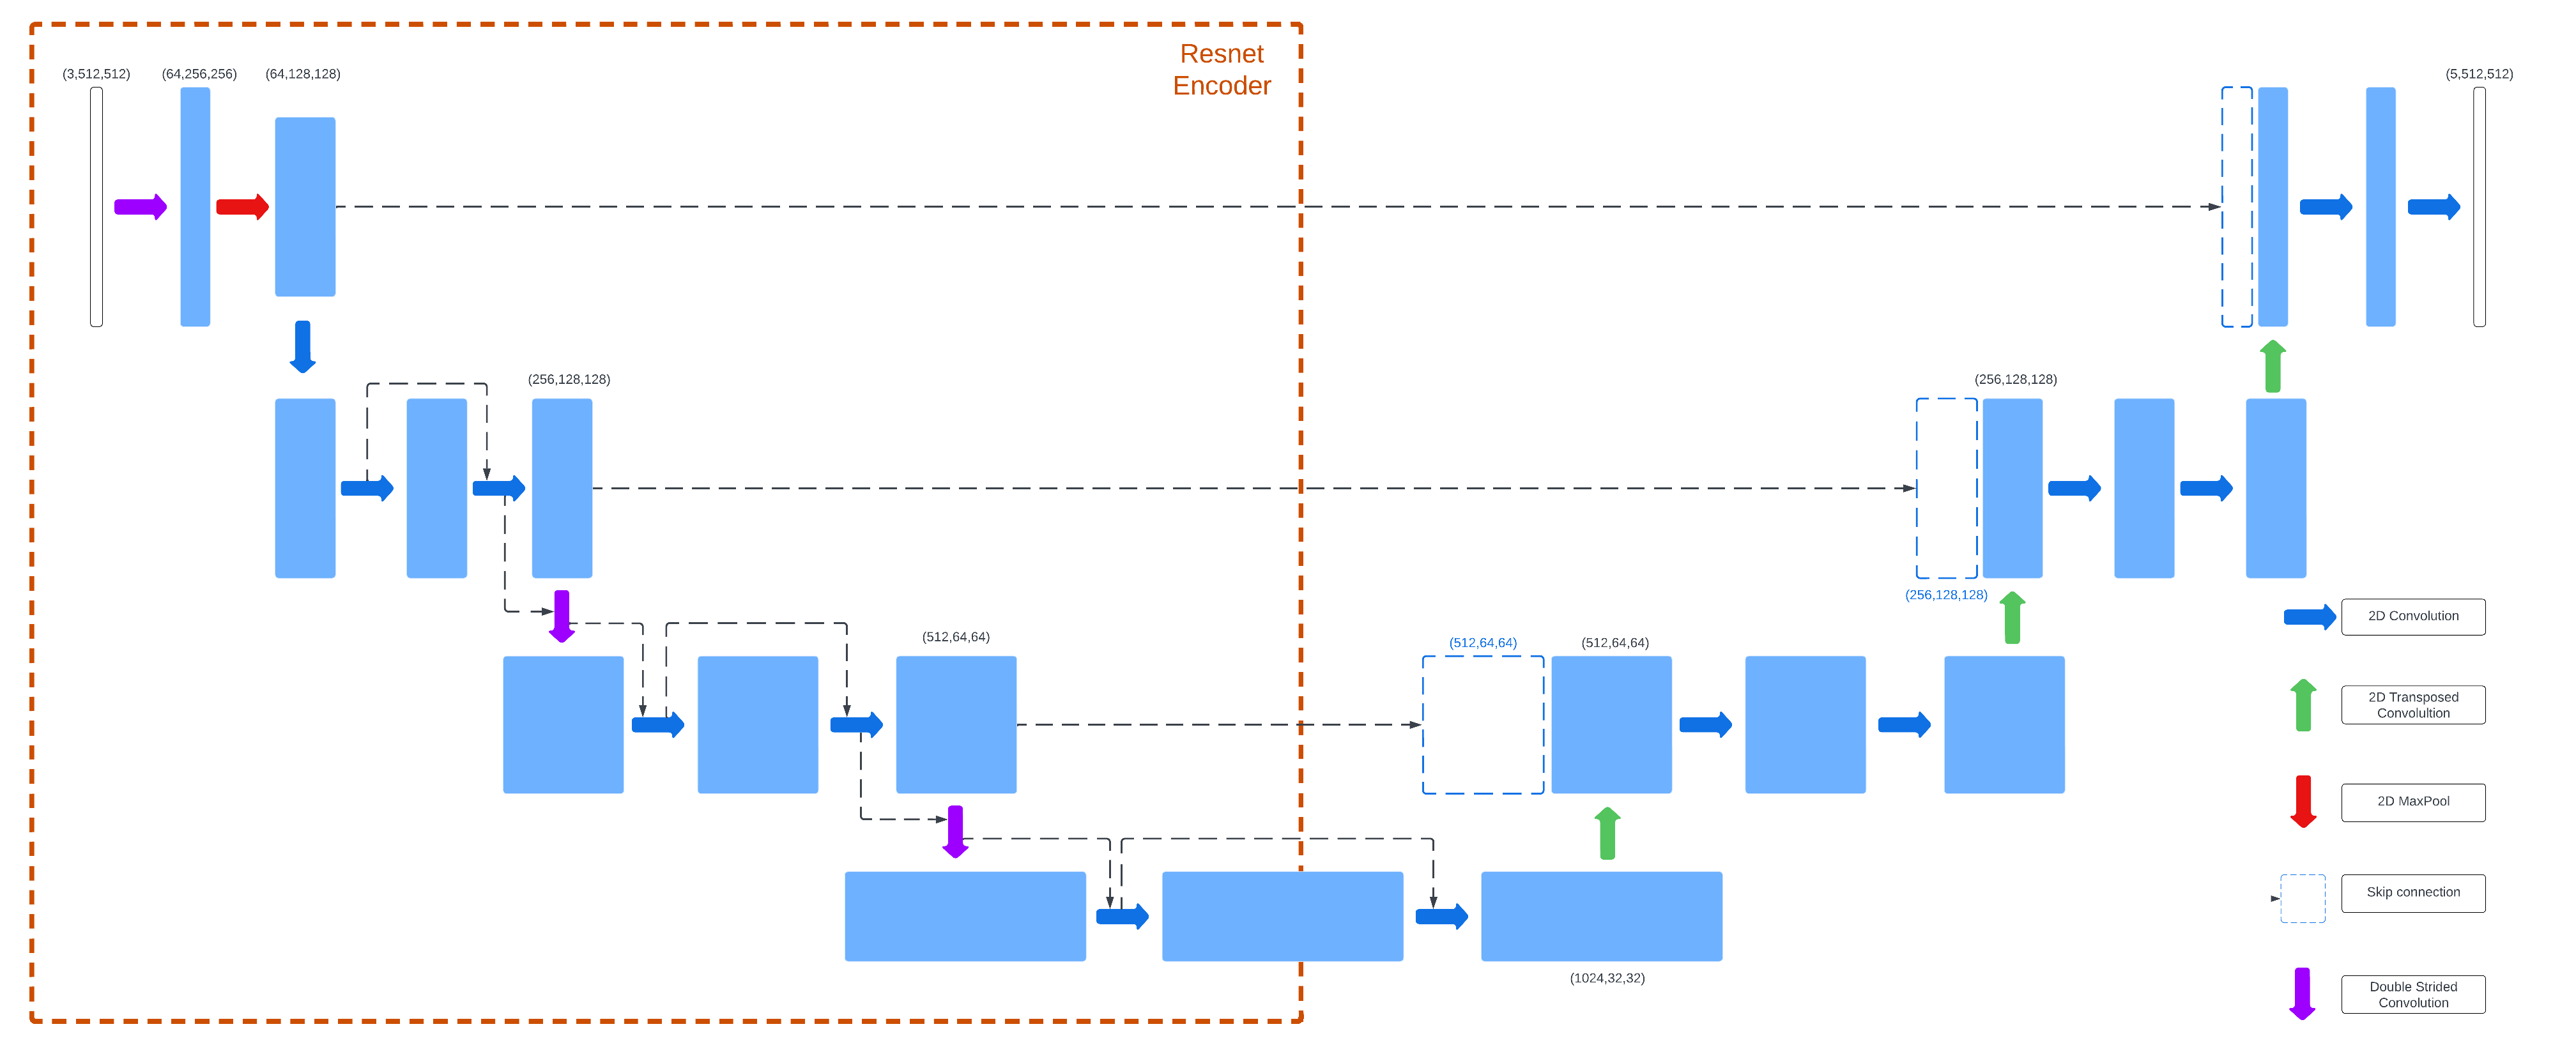

Resnet U-Net with simple encoder
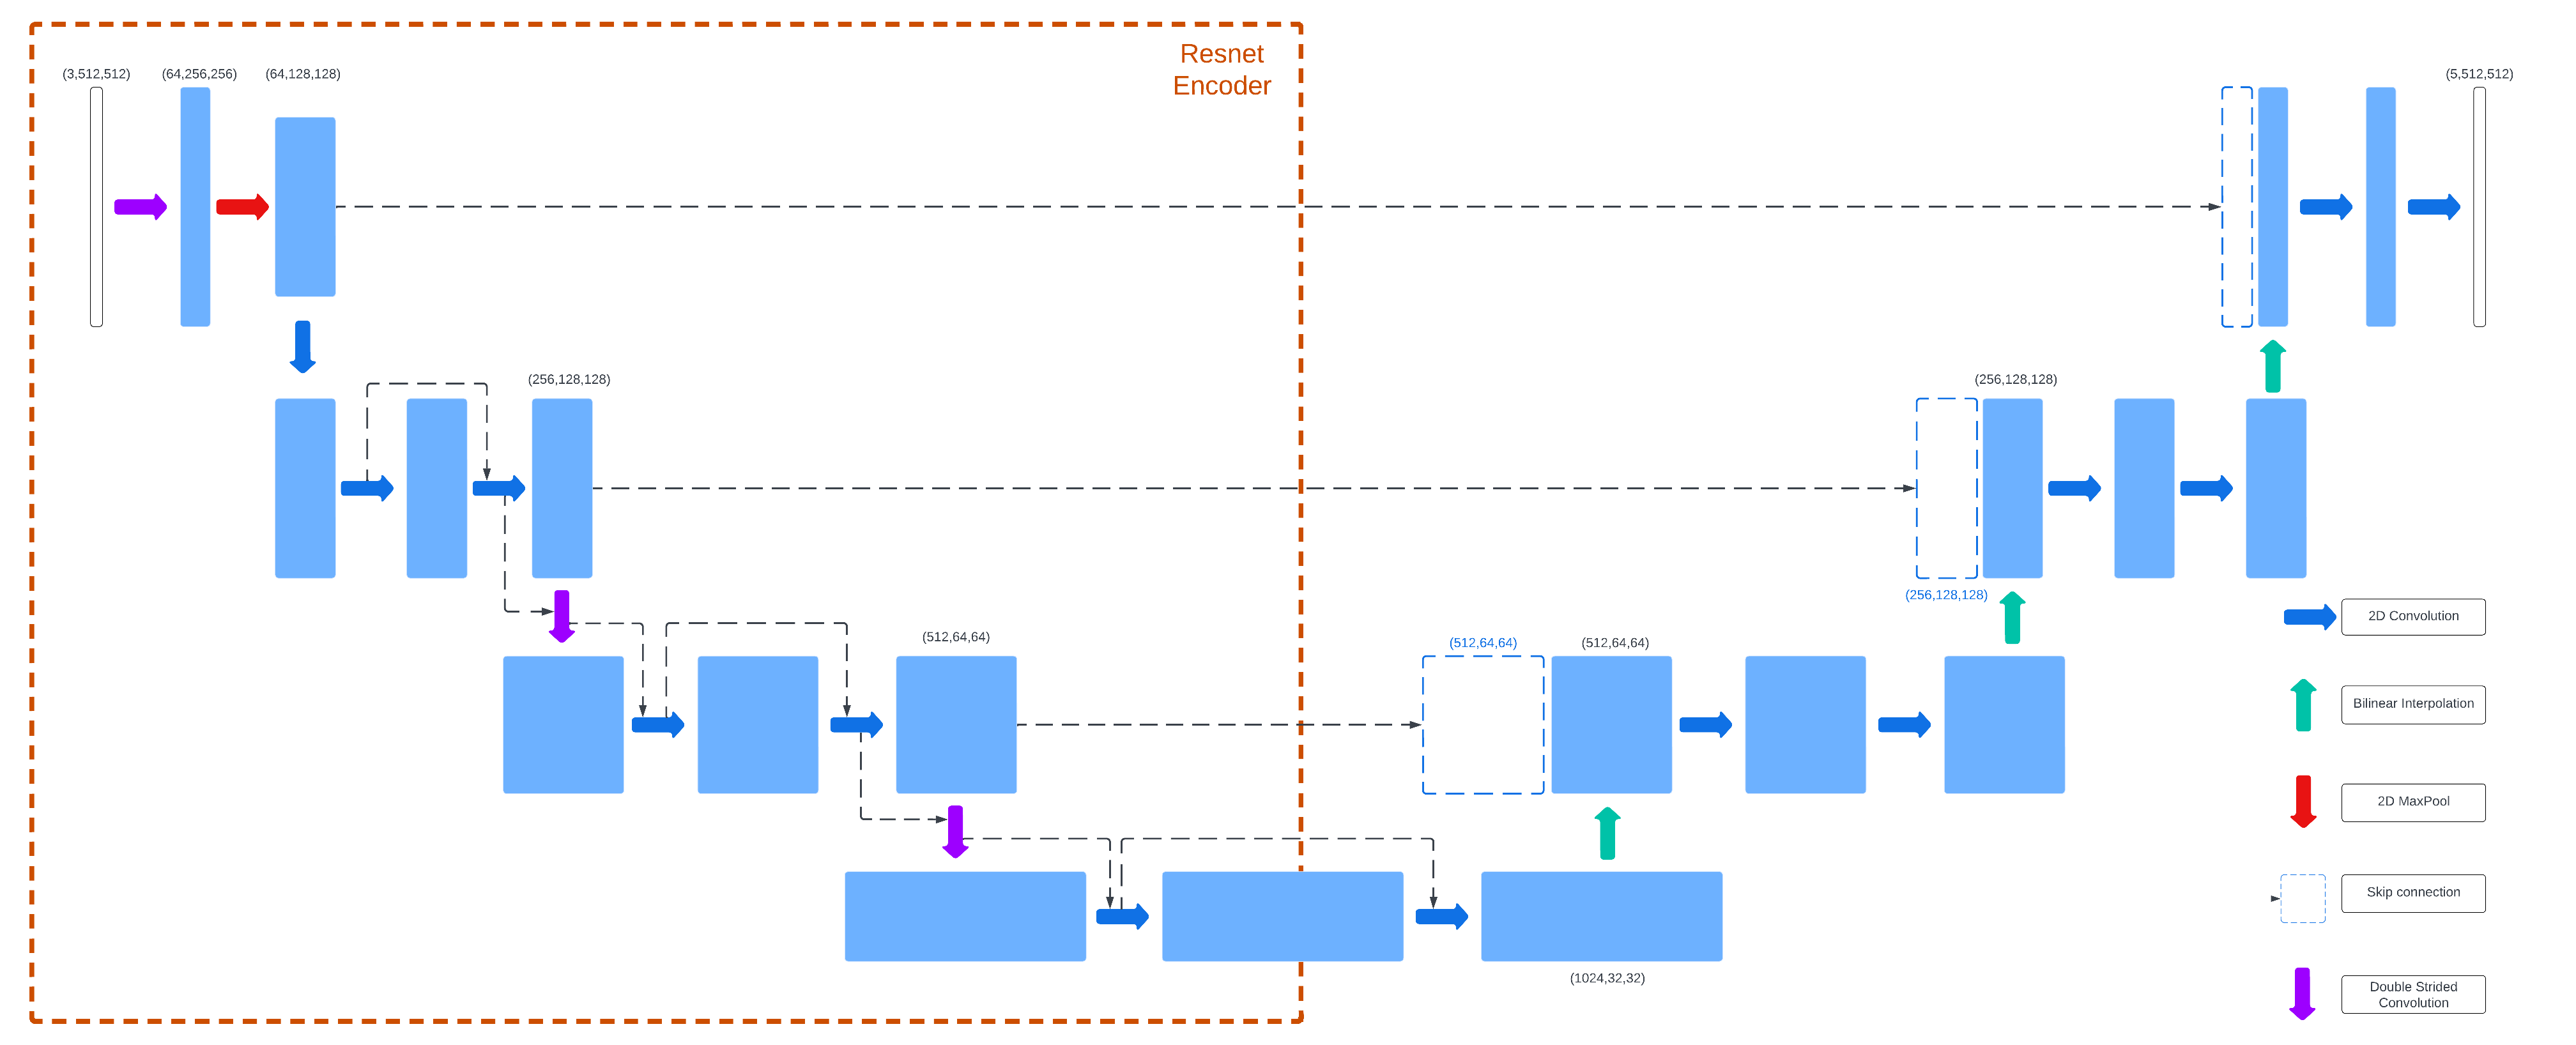

Resnet U-Net with multi-task training
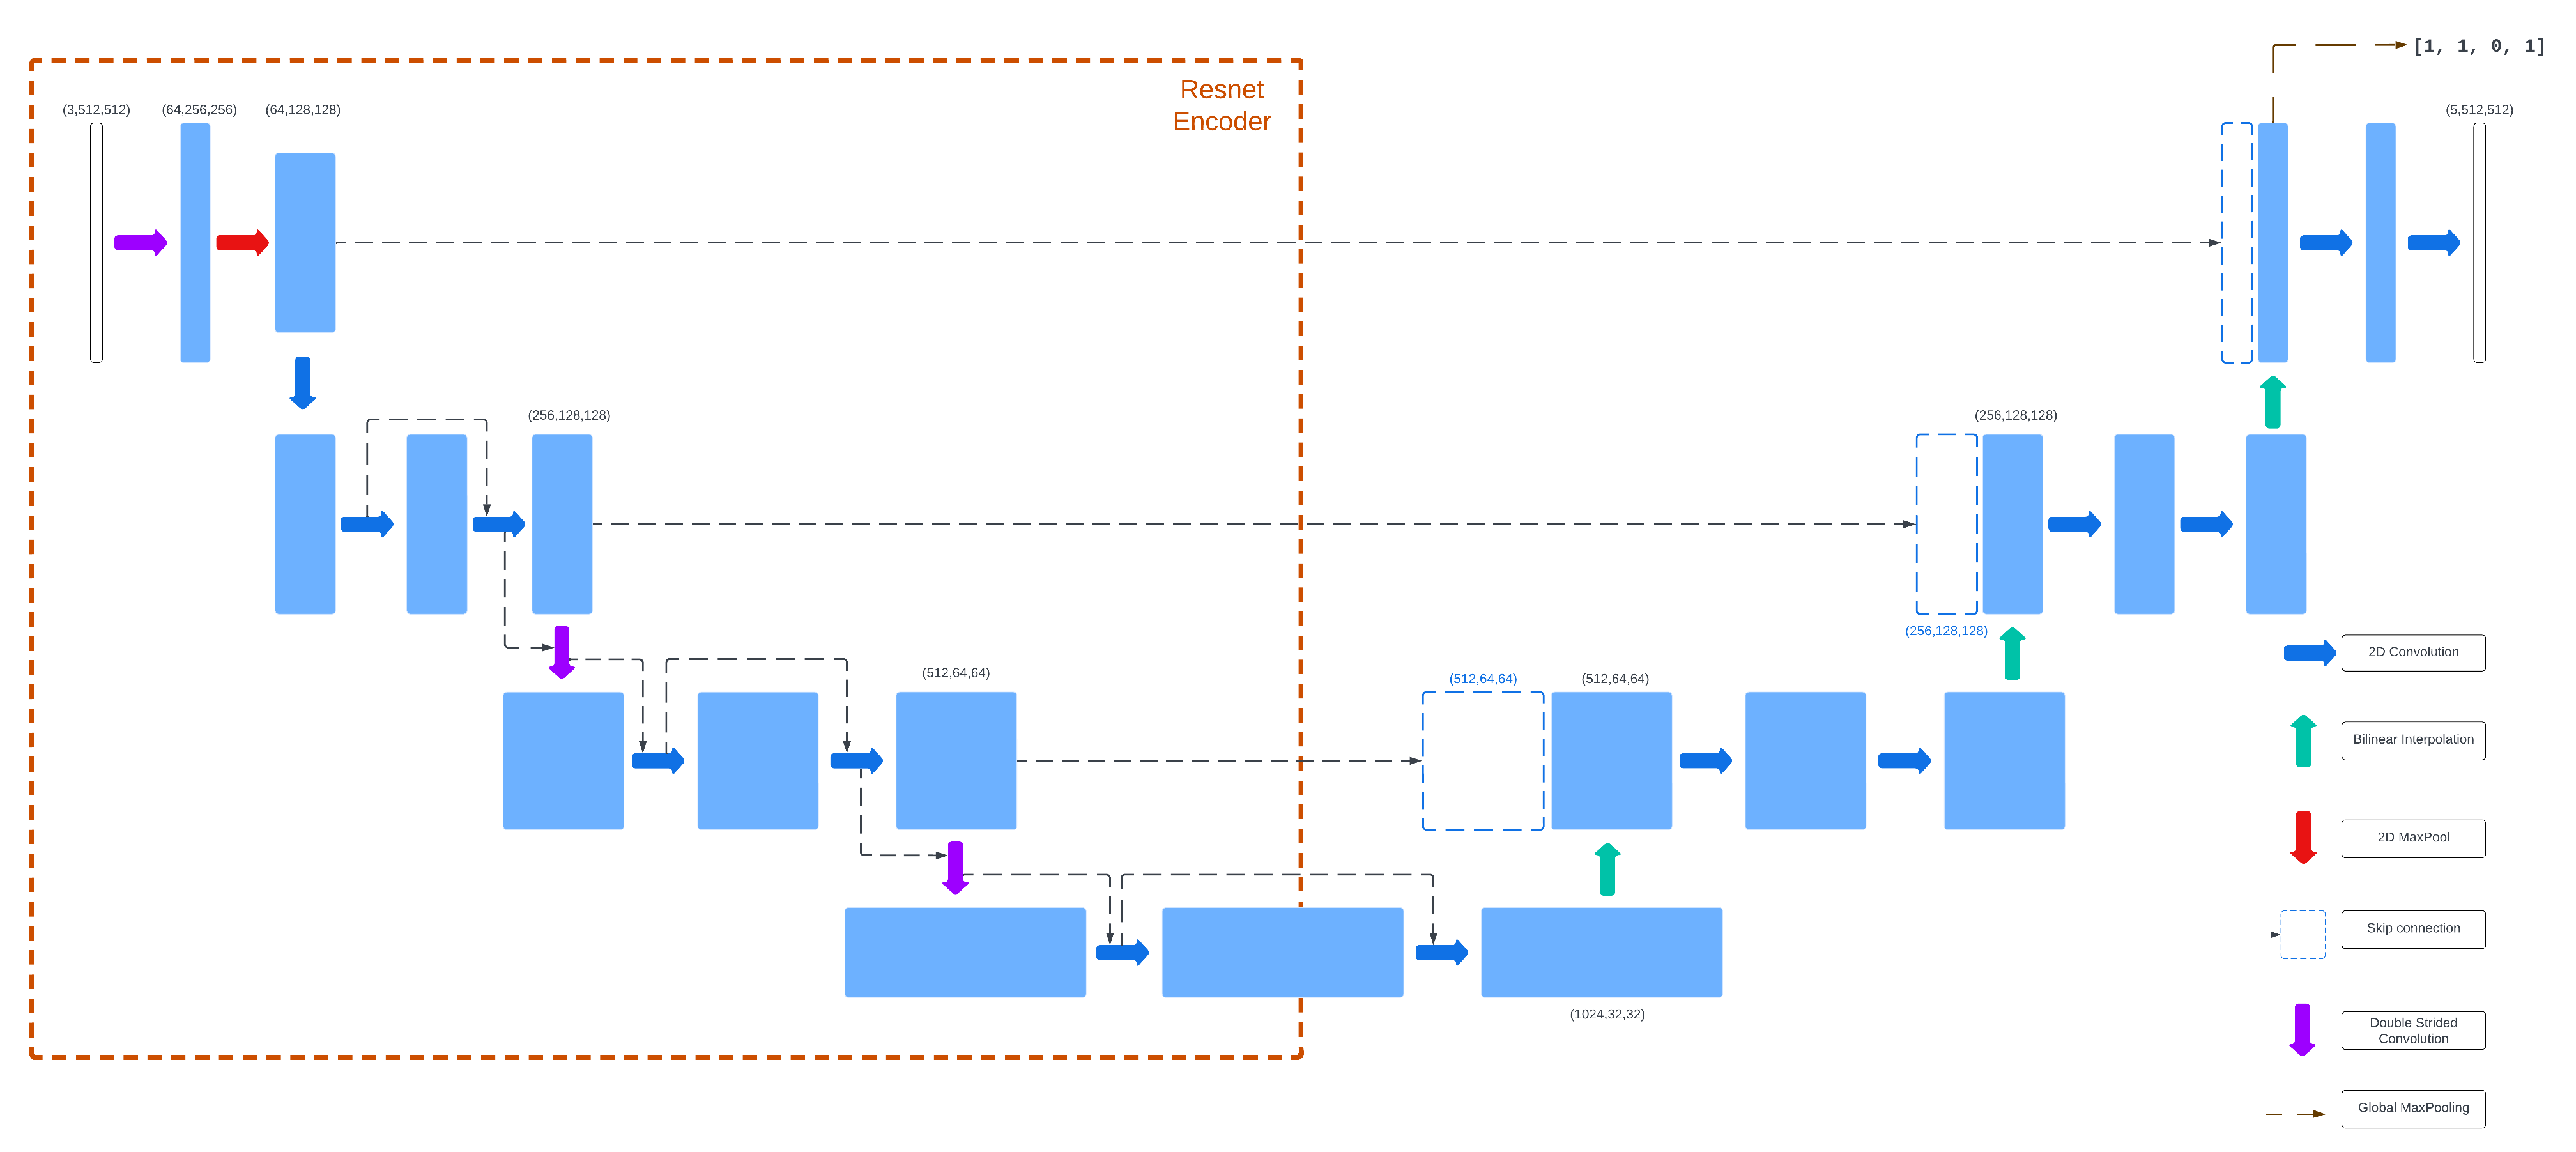

In [22]:
from torchvision.models import resnet50, ResNet50_Weights

In [23]:
class ResNetUNet(nn.Module, BaseModel):

    def __init__(self, num_classes, simple=False, sigmoid=False, attention=False):

        super().__init__()

        self.activations = [None]
        resnet_model = resnet50(weights=ResNet50_Weights.DEFAULT)

        self.resnet_backbone = nn.Sequential(*(list(resnet_model.children())[0:7]))
        for param in self.resnet_backbone.parameters():
            param.requires_grad = False

        filters = [512, 256, 64, 64]
        self.decoder = Decoder(1024, filters, num_classes, simple, sigmoid)
        self.attention = attention
        if attention == 1:
            self.dual_attention = CSA(1024)
            self.dual_attention_2 = CSA(filters[0])
        elif attention == 2:
            self.dual_attention = DualAttention(1024)
            self.dual_attention_2 = DualAttention(filters[0])
        elif attention > 2 or attention < 0:
            print("Attention can only be 0, 1, or 2")
            return -1
        else:
            pass
    
    def getActivations(self):
        def hook(model, input, output):
            self.activations.append(output)
        return hook
    
    def forward(self, input):

        self.activations = [None]

        hr1 = self.resnet_backbone[2].register_forward_hook(self.getActivations())
        hr2 = self.resnet_backbone[4][2].register_forward_hook(self.getActivations())
        hr3 = self.resnet_backbone[5][-1].register_forward_hook(self.getActivations())

        resnet_output = self.resnet_backbone(input)
        
        if self.attention:
            resnet_output = self.dual_attention(resnet_output)
            self.activations[-1] = self.dual_attention_2(self.activations[-1])

        final_output = self.decoder(resnet_output, self.activations[::-1])

        hr1.remove()
        hr2.remove()
        hr3.remove()

        return final_output

### Attention

#### Dual Attention

##### Spatial Attention
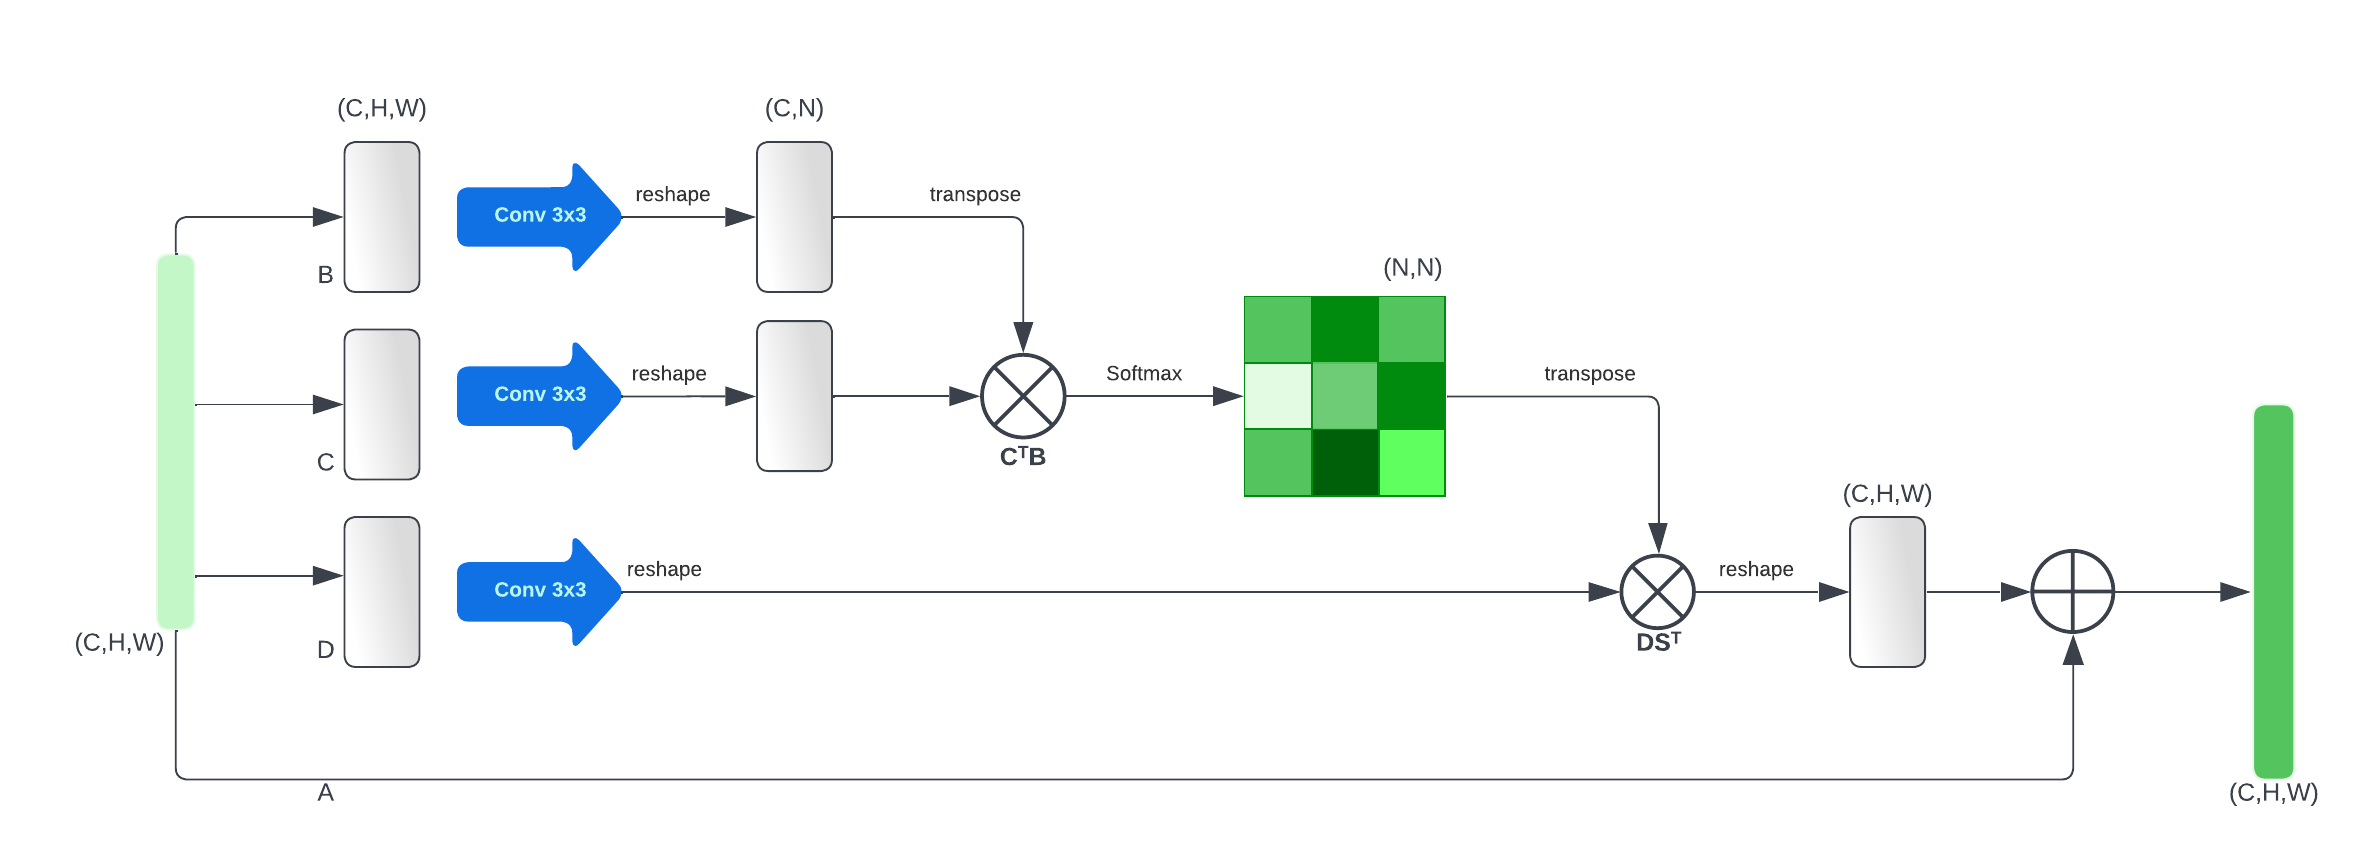

##### Channel Attention
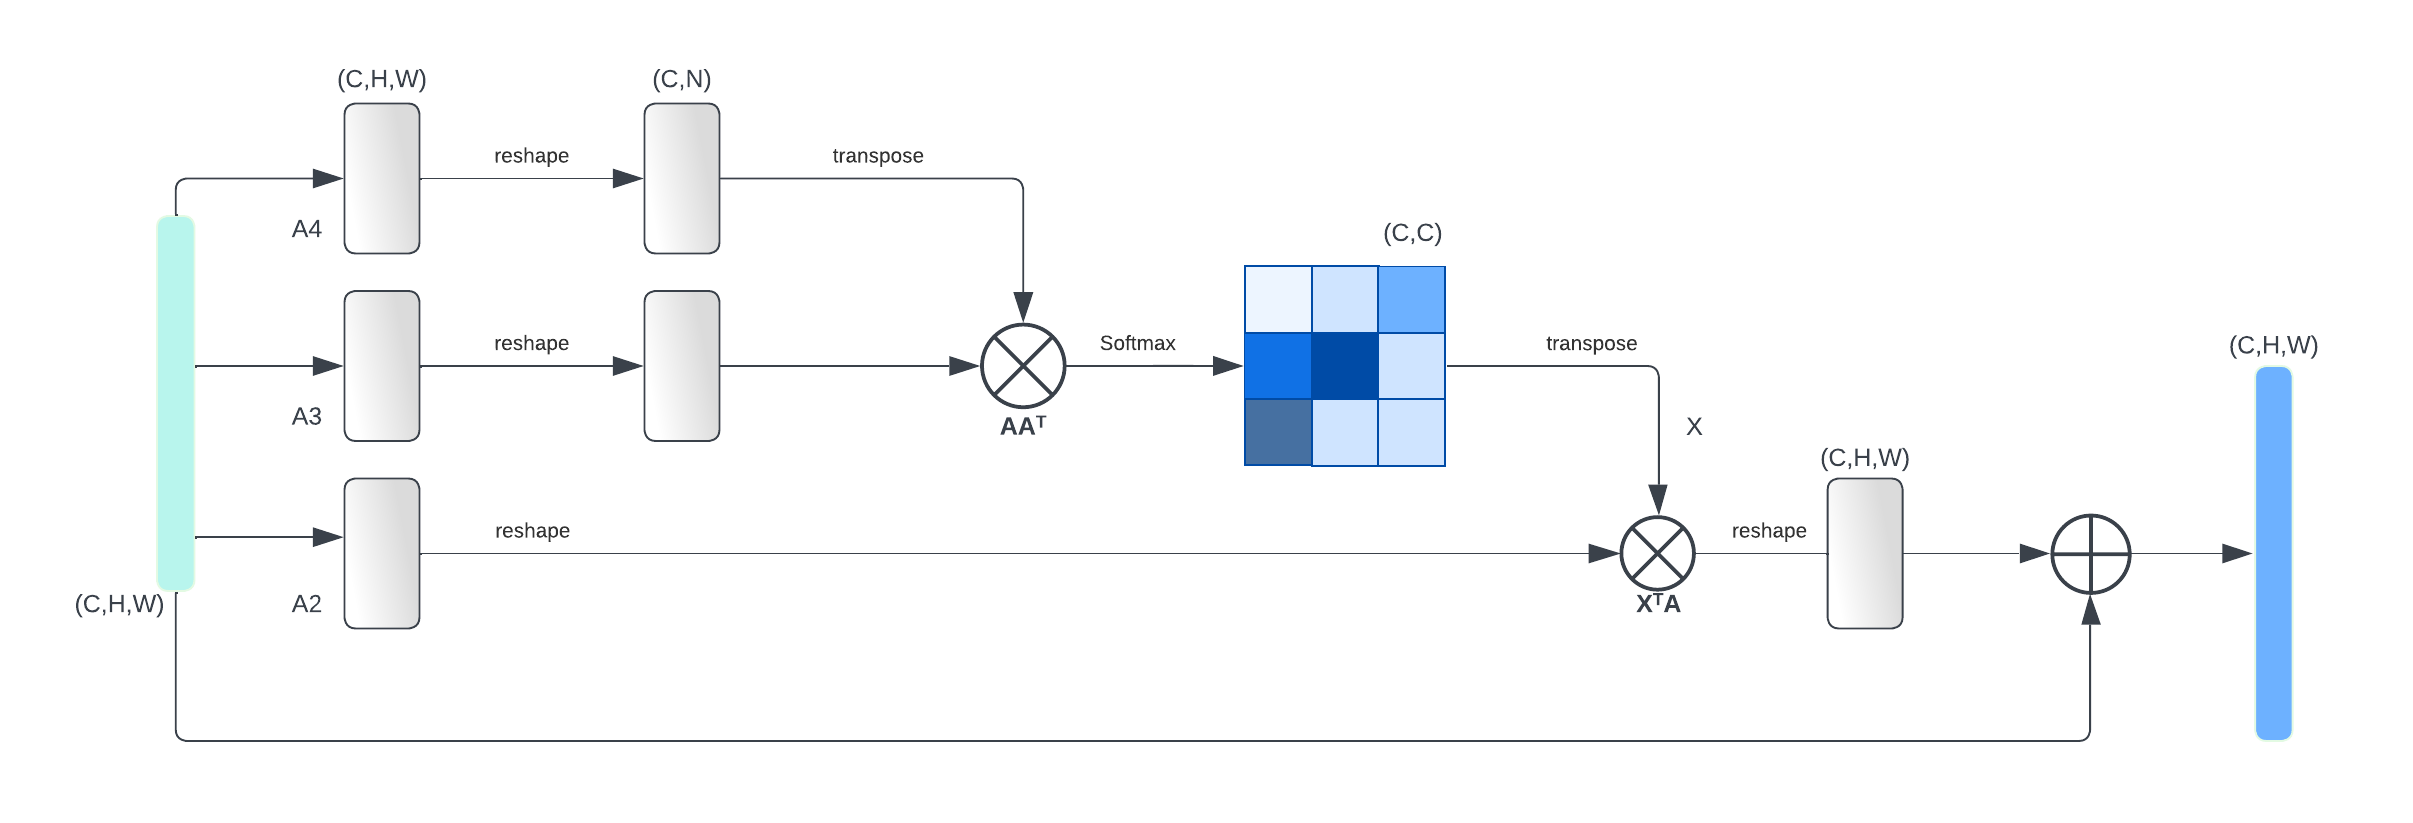

In [1]:
import torch
from torch import nn

class SpatialAttention(nn.Module):

    def __init__(self, in_channels):

        super(SpatialAttention, self).__init__()

        self.C = in_channels

        self.alpha = nn.Parameter(torch.tensor(0.0))

        self.conv1 = nn.Conv2d(in_channels=self.C, out_channels=self.C, kernel_size=1, stride=1)
        self.conv2 = nn.Conv2d(in_channels=self.C, out_channels=self.C, kernel_size=1, stride=1)
        self.conv3 = nn.Conv2d(in_channels=self.C, out_channels=self.C, kernel_size=1, stride=1)
        self.relu = nn.ReLU()

    
    def forward(self, x):
        

        H = x.shape[2]
        W = x.shape[3]

        N = H * W

        a = x
        b = self.relu(self.conv1(x))
        c = self.relu(self.conv2(x))
        d = self.relu(self.conv3(x))

            

        b = b.view(-1, self.C, N)
        c = c.view(-1, self.C, N)
        d = d.view(-1, self.C, N)

        c = torch.bmm(c.transpose(1, 2), b)
        S = nn.Softmax(dim=1)(c)
        S = S.transpose(1, 2)

        d = self.alpha * torch.bmm(d, S)
        d = d.view(-1, self.C, H, W)
        E = a + d

        return E


class ChannelAttention(nn.Module):

    def __init__(self, in_channels):

        super(ChannelAttention, self).__init__()
        self.beta = nn.Parameter(torch.tensor(0.0))

        self.C = in_channels
    
    def forward(self, x):

        a1=a2=a3=a4 = x
        H = x.shape[2]
        W = x.shape[3]
        N = H * W

        a2 = a2.view(-1, self.C, N)
        a3 = a3.view(-1, self.C, N)
        a4 = a4.view(-1, self.C, N)
        a4 = a4.transpose(1, 2)

        aa_T = torch.bmm(a3, a4)
        X = nn.Softmax(dim=1)(aa_T)
        X = X.transpose(1, 2)

        a2_pass = torch.bmm(X, a2) * self.beta
        a2_pass = a2_pass.view(-1, self.C, H, W)

        E = a1 + a2_pass

        return E

class DualAttention(nn.Module):

    def __init__(self, in_channels):
        
        super(DualAttention, self).__init__()
        self.C = in_channels

        self.conv1 = nn.Conv2d(self.C, self.C, 1)
        self.conv2 = nn.Conv2d(self.C, self.C, 1)

        self.sam = SpatialAttention(in_channels)
        self.cam = ChannelAttention(in_channels)

    def forward(self, x):

        e1 = self.sam(x)
        e2 = self.sam(x)

        e1 = self.conv1(e1)
        e2 = self.conv2(e2)

        F = e1 + e2
        return F

### Compact Split Attention

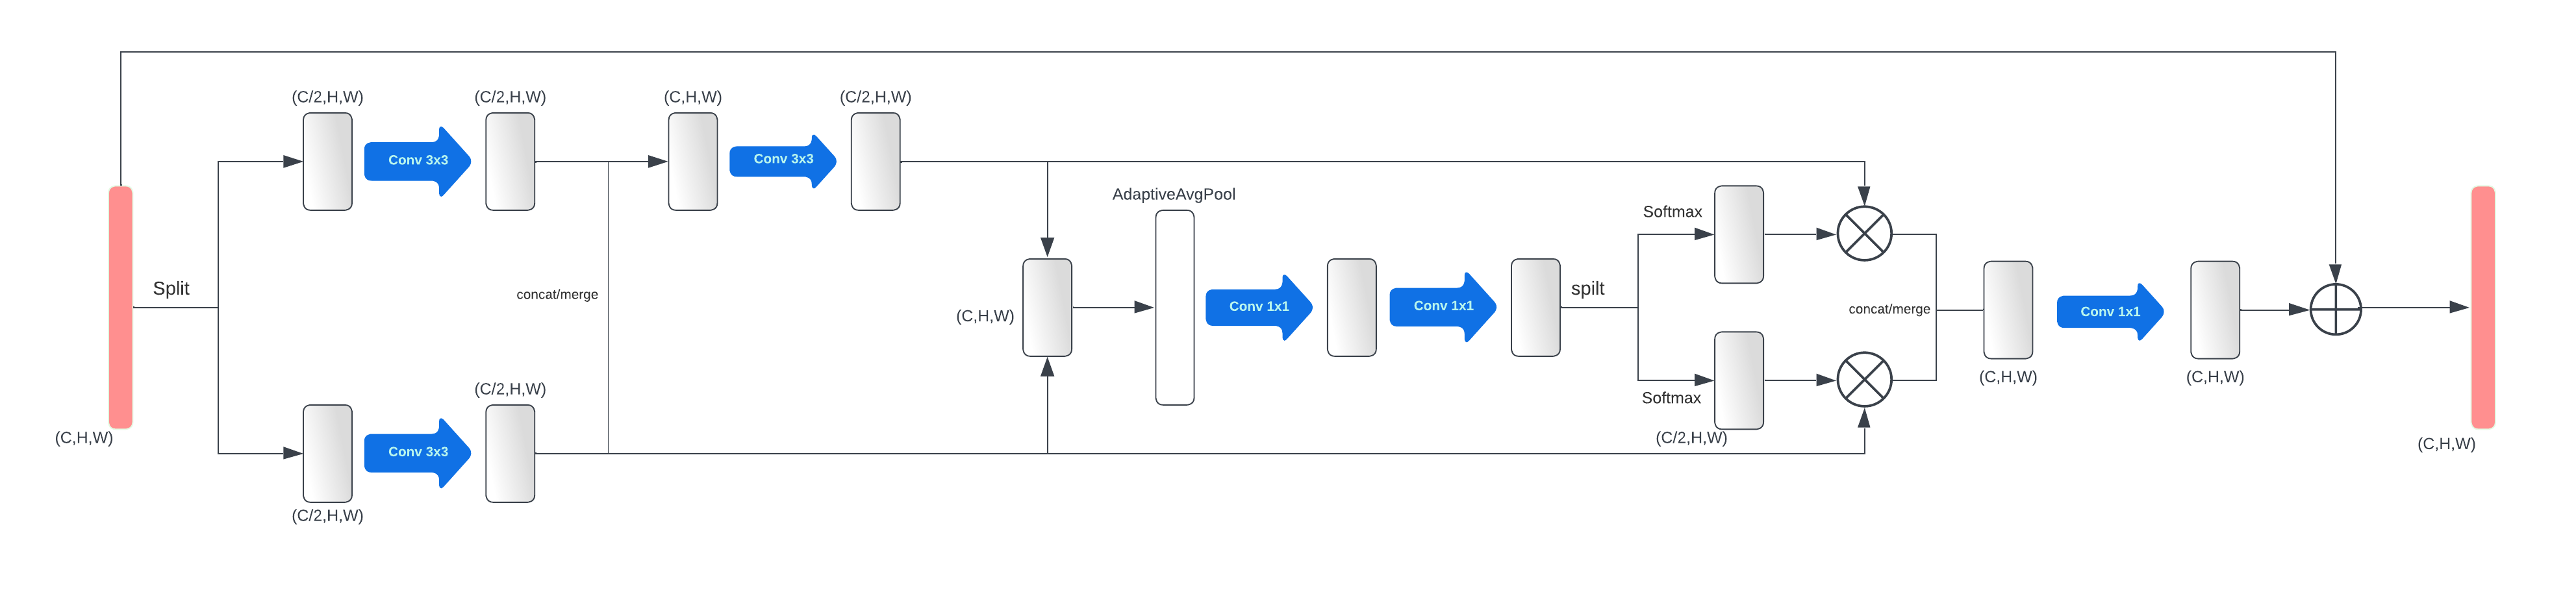

In [17]:
class CSA(nn.Module):

    def __init__(self, in_channels):
        
        super(CSA, self).__init__()

        self.C = in_channels
        self.C_by_2 = int(in_channels / 2)
        self.conv_1 = nn.Conv2d(in_channels, in_channels, 1)
        self.conv_3x3_1 = nn.Conv2d(in_channels=self.C_by_2, out_channels=self.C_by_2, kernel_size=3, stride=1, padding="same")
        self.conv_3x3_2 = nn.Conv2d(in_channels=self.C_by_2, out_channels=self.C_by_2, kernel_size=3, stride=1, padding="same")
        self.conv_3x3_3 = nn.Conv2d(in_channels=in_channels, out_channels=self.C_by_2, kernel_size=3, stride=1, padding="same")

        self.group_1 = nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=1, stride=1)
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()
        self.group_2 = nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=1, stride=1)
        self.softmax = nn.Softmax(dim=1)
        self.final_conv = nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=1, stride=1)

    def forward(self, input):

        H = input.shape[2]
        W = input.shape[3]

        N = H * W

        F = self.conv_1(input)
        F_1, F_2 = F.split(int(self.C / 2), dim=1)

        F_1 = self.conv_3x3_1(F_1)
        F_2 = self.conv_3x3_2(F_2)
        F_2 = torch.concat([F_1, F_2], dim=1)
        F_2 = self.conv_3x3_3(F_2)

        F = torch.concat([F_1, F_2], dim=1)

        #Global average pooling
        F = nn.AdaptiveAvgPool2d((H, W))(F)

        F = self.group_1(F)
        F = self.bn(F)
        F = self.relu(F)
        F = self.group_2(F)

        F_1_s, F_2_s = F.split(int(self.C / 2), dim=1)

        F_1_s = self.softmax(F_1)
        F_2_s = self.softmax(F_2)

        F_1_final = F_1 * F_1_s
        F_2_final = F_2 * F_2_s

        F_final = torch.concat([F_1_final, F_2_final], dim=1)
        F_final = self.final_conv(F_final)

        output = F_final + input

        return output

## Loss Functions

### Cross-Entropy

Cross-Entropy Loss
The cross-entropy loss function is commonly used for multi-class image segmentation tasks. Given a set of $N$ images and their corresponding segmentation masks, where each pixel is assigned a label from a set of $K$ classes, the cross-entropy loss can be defined as:

- $L_{CE}$: The cross-entropy loss.
- $y_{i,j}$: The ground truth label for pixel $i$ in class $j$.
- $\hat{y}_{i,j}$: The predicted probability for pixel $i$ in class $j$.
- $log()$: The natural logarithm function.
- $\sum$: The summation operator.
- $N$: The total number of pixels in the segmentation mask.
The cross-entropy loss is computed as:

$$L_{CE} = -\frac{1}{N}\sum_{i=1}^{N}\sum_{j=1}^{K} y_{i,j} log(\hat{y}_{i,j})$$

The loss penalizes the model for assigning high probability to the wrong class and encourages it to assign high probability to the correct class.

In [31]:
class CrossEntropy4D(nn.Module):
    def __init__(self, class_weights=None):
        super(CrossEntropy4D, self).__init__()
        
        self.cross_entropy_loss = nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, prediction, target):
        # Reshape predictions and targets to (batch_size * height * width, num_classes)
        predictions_2d = prediction.permute(0, 2, 3, 1).reshape(-1, prediction.size()[1])
        targets_2d = target.permute(0, 2, 3, 1).reshape(-1, target.size()[1])
        loss = self.cross_entropy_loss(predictions_2d, targets_2d.argmax(1))
        return loss

### Dice Loss
The Dice loss, also known as the Sørensen–Dice coefficient, is commonly used for image segmentation tasks. It measures the similarity between the predicted segmentation and the ground truth segmentation

The Dice loss is computed as:

$$L_{Dice} = 1 - \frac{2\sum_{i}^{N}\sum_{j}^{K} y_{true,i,j}y_{pred,i,j}}{\sum_{j}^{K}|y_{true,j}| + \sum_{j}^{K}|y_{pred,j}|}$$

where:

- $L_{Dice}$: The Dice loss.
- $y_{true,i,j}$: The ground truth label for pixel $i$ in class $j$.
- $y_{pred,i,j}$: The predicted probability for pixel $i$ in class $j$.
- $N$: The total number of pixels.
- $K$: The number of classes.
- $\sum$: The summation operator.
- $|.|$: The cardinality operator, which returns the number of elements in a set.

In [105]:
class DiceLoss(nn.Module):
    def __init__(self, num_classes, log_loss=False):
        super(DiceLoss, self).__init__()
        self.num_classes = num_classes
        self.log_loss = log_loss

    def forward(self, prediction, target):
        prediction = torch.softmax(prediction, dim=1)
        prediction = prediction.view(prediction.size(0), self.num_classes, -1)
        target = target.view(target.size(0), self.num_classes, -1)
        intersection = (prediction * target).sum(dim=-1)
        union = prediction.sum(dim=-1) + target.sum(dim=-1)
        dice = 2 * intersection / union

        if self.log_loss:
            dice = torch.log(dice)

        return 1 - dice.mean()

### DiceCE

The Categorical Cross Entropy Dice loss is a combination of two popular loss functions, the Categorical Cross Entropy and the Dice loss. It is used for multiclass image segmentation tasks and aims to balance the contribution of each loss function to the overall loss.

$$L_{CCE-Dice} = L_{CCE} + \beta \cdot L_{Dice}$$

where:
- $L_{CCE-Dice}$: The Categorical Cross Entropy Dice loss.
- $L_{CCE}$: The Categorical Cross Entropy loss.
- $L_{Dice}$: The Dice loss.
- $\beta$: A hyperparameter that balances the contribution of each loss function to the overall loss.

In [105]:
class DiceLoss(nn.Module):
    def __init__(self, num_classes, log_loss=False):
        super(DiceLoss, self).__init__()
        self.num_classes = num_classes
        self.log_loss = log_loss

    def forward(self, prediction, target):
        prediction = torch.softmax(prediction, dim=1)
        prediction = prediction.view(prediction.size(0), self.num_classes, -1)
        target = target.view(target.size(0), self.num_classes, -1)
        intersection = (prediction * target).sum(dim=-1)
        union = prediction.sum(dim=-1) + target.sum(dim=-1)
        dice = 2 * intersection / union

        if self.log_loss:
            dice = torch.log(dice)

        return 1 - dice.mean()

### Regularized CE Loss

The regularized version of the CE loss adds a regularization parameter to the standard CE loss to manipulate the hidden label marginal bias of the loss function and improve performance with imbalanced classes.

$$L_{Reg-CE} = L_{CE} + \lambda R[y;p]$$

where: 

- $L_{Reg-CE}$ : The regularized loss function
- $L_{CE}$ : Standard cross entropy loss function
- $\lambda$ : Parameter controlling the influence of the regularizer
- $R[y;p]$ : The regularizer function for the label marginal bias between the ground truth label proportion and the predicted label proportion

#### L1 Regularizer

Given the predicted label-marginal proportion ${p} = (\hat{p}k){1 \le k \le K}$ and the ground truth label-marginal proportion ${y} = (\hat{y}k){1 \le k \le K}$, the loss function calculates the difference between the predicted and ground truth proportions for each class, and then sums up these differences.

This is computed as:

$$L_1(p, y) = \sum^K_{k=1}|\hat{y}_k - \hat{p}_k|$$

In [32]:
class L1Loss(nn.Module):
    def __init__(self):
        super(L1Loss, self).__init__()

    def forward(self, prediction, ground_truth):
        # apply softmax on the prediction
        prediction = torch.softmax(prediction, dim=1)

        # calculate the ground truth marginal probabilities
        #y = torch.sum(ground_truth, dim=1) / 512 * 512
        y = torch.mean(ground_truth, dim=(2,3))

        # calculate the predicted marginal probabilities
        #p = torch.sum(predictionction, dim=1) / 512 * 512
        p = torch.mean(prediction, dim=(2,3))

        # calculate L1 loss
        loss = torch.mean(torch.sum(torch.abs(y - p), dim=1))

        return loss

#### KL Regularizer

Similar to the L1 regularizer, the KL regularizer computes the "distance" of the grount-truth label distribution from the predicted label distribution over all classes.

$$D_{KL}({y} || {p}) = \sum^{K}_{k=1}\hat{y}_klog({\hat{y}_k\over\hat{p}_k})$$

In [33]:
import torch

class KLLoss(torch.nn.Module):
    
    def __init__(self):
        
        super(KLLoss, self).__init__()
        
    def forward(self, prediction, ground_truth, eps=1e-5):
        y = torch.mean(ground_truth, dim=(2,3)) + eps
        p = torch.mean(torch.nn.functional.softmax(prediction, dim=1), dim=(2,3)) + eps
        
        loss = torch.sum(y * torch.log(y / p), dim=1)
        return torch.mean(loss)

#### Overall Loss

In [34]:
class CompoundLoss(nn.Module):
    
    def __init__(self, l1=True, lamb=0.1, weights=None):
        
        super(CompoundLoss, self).__init__()
        self.seg_loss = CrossEntropy4D(class_weights=weights)
        self.reg_loss = L1Loss() if l1 else KLLoss()
        self.lamb = lamb
    
    def forward(self, prediction, target):
        
        ce_loss = self.seg_loss(prediction, target)
        reg_loss = self.lamb * self.reg_loss(prediction, target)
        
        loss = ce_loss + reg_loss
        
        return loss
    

## Image Preprocessing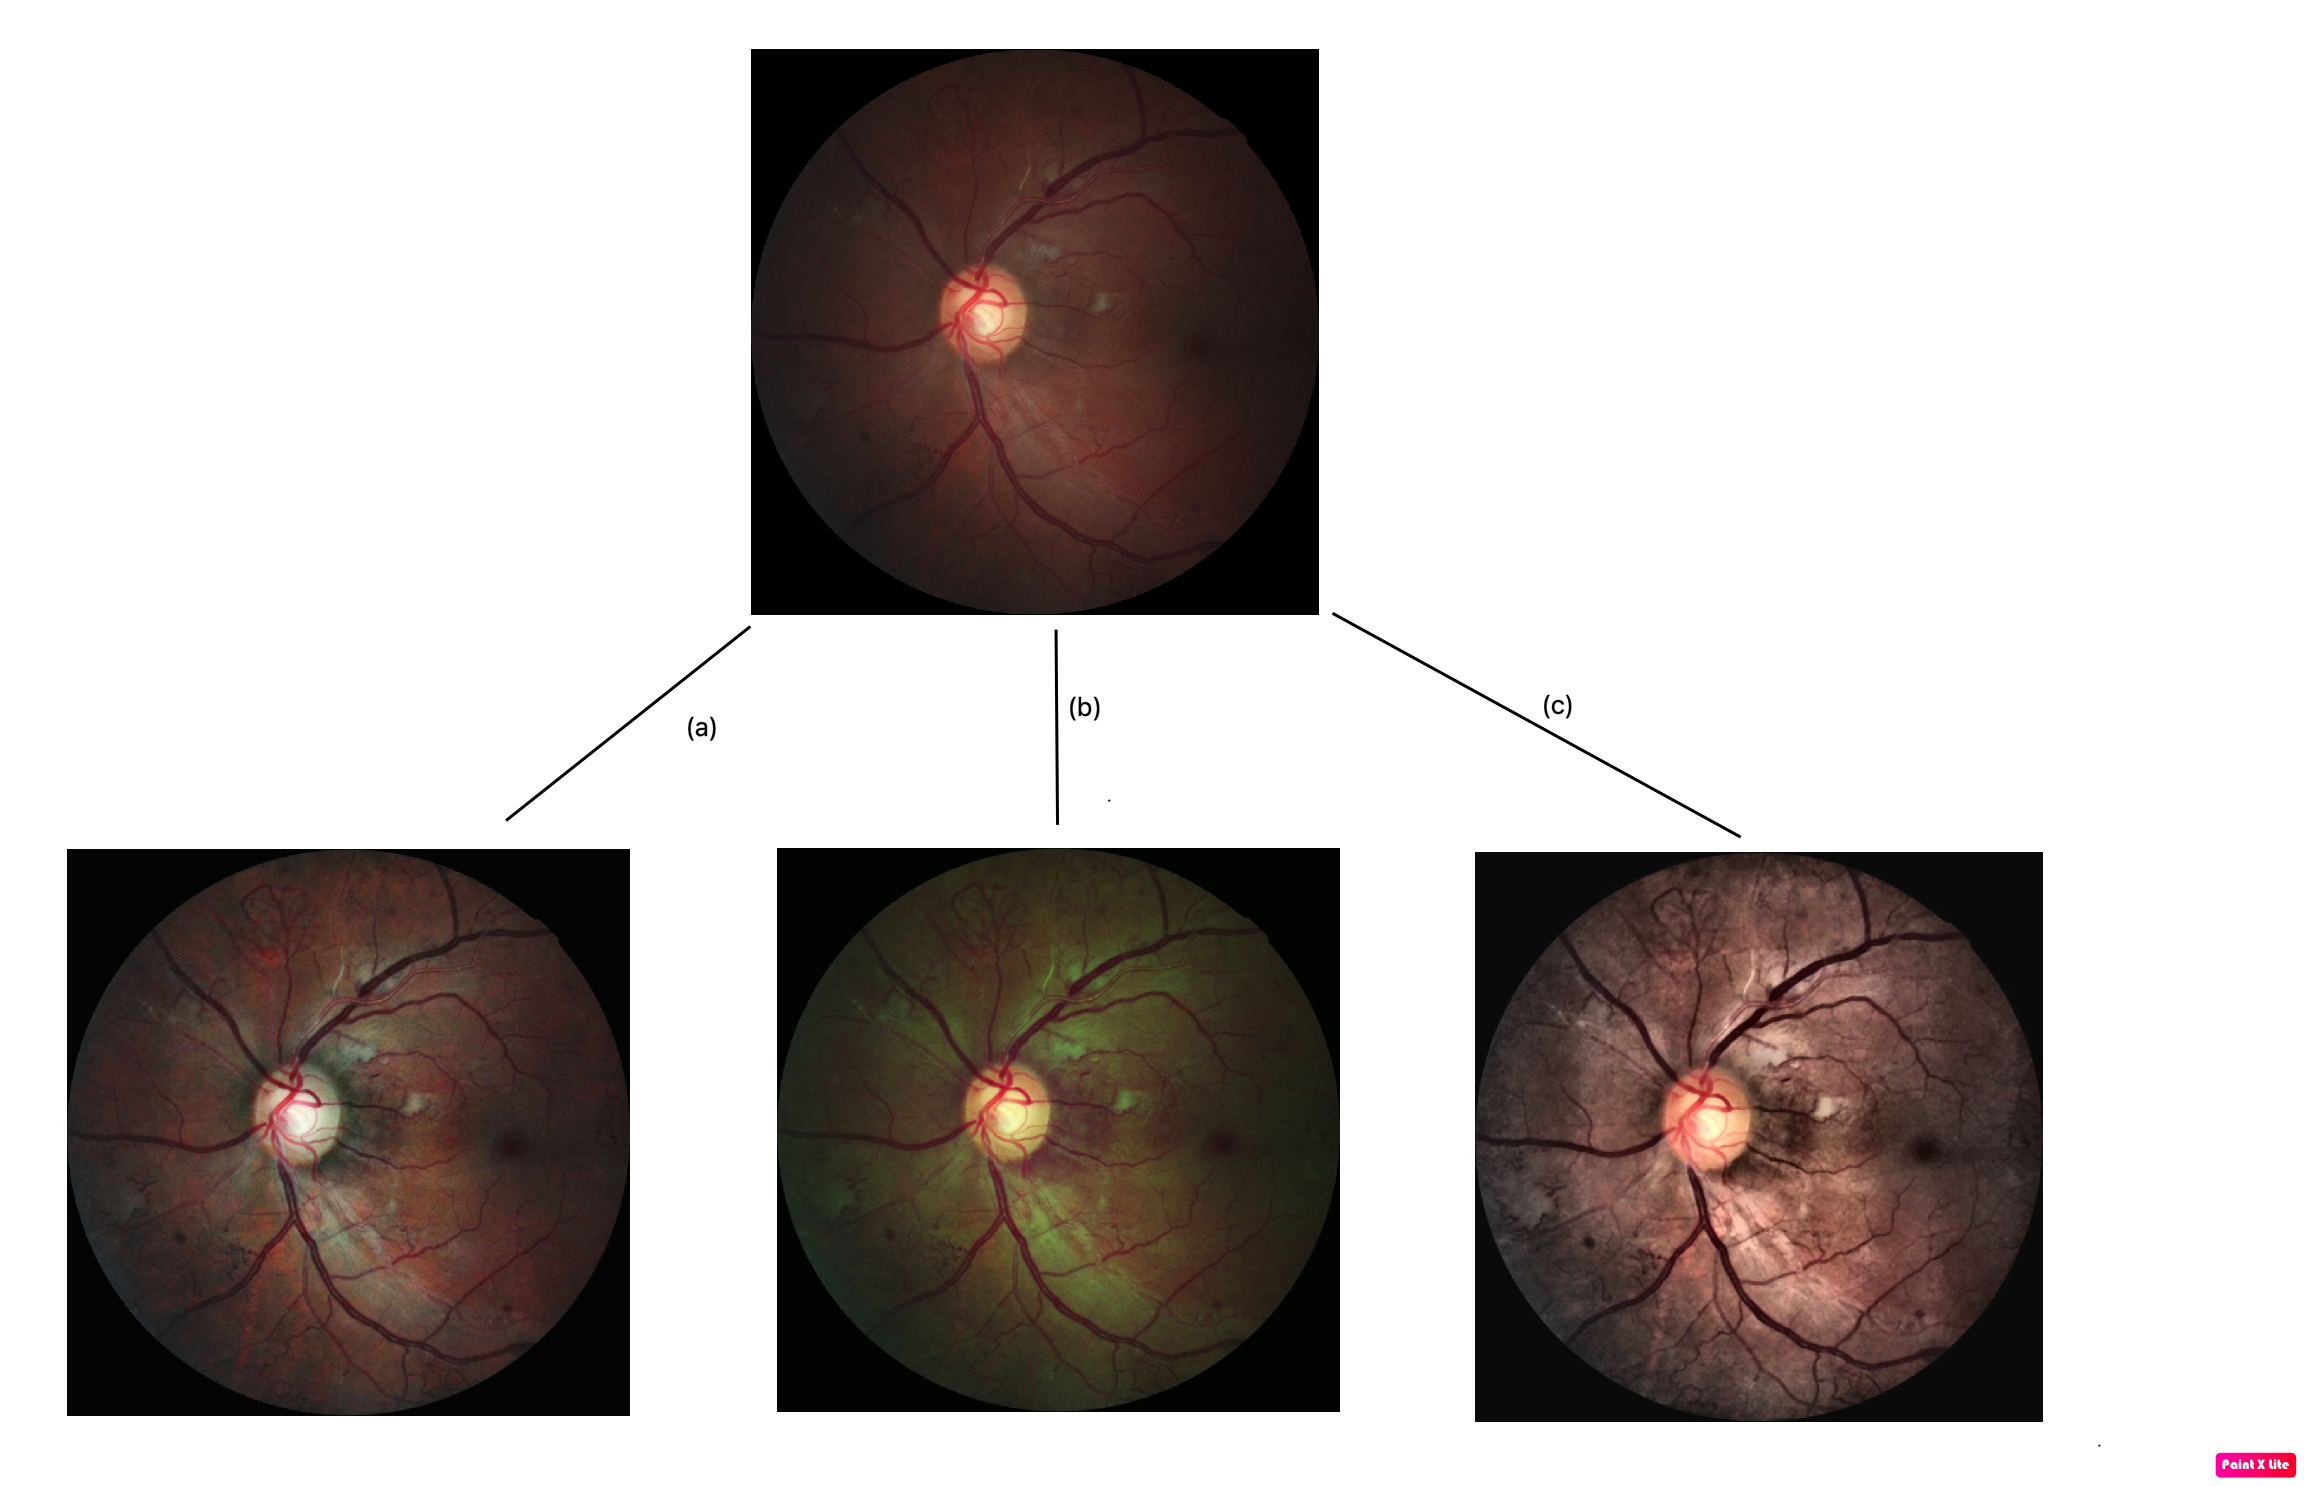

In [ ]:
clahe = cv2.createCLAHE(clipLimit=6, tileGridSize=(8,8))

def image_enhancement_one(file_name):

    image = cv2.imread(file_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    #Extracting The Color Channels
    image_red_channel = image[:,:, 0]
    image_green_channel = image[:,:, 1]
    image_blue_channel = image[:,:, 2]

    #Applying the median filter on each channel to reduce the noise
    median_red_channel = cv2.medianBlur(image_red_channel, 5)
    median_green_channel = cv2.medianBlur(image_green_channel, 5)
    median_blue_channel = cv2.medianBlur(image_blue_channel, 5)

    #Applying CLAHE on each channel
    clahe_red_channel = clahe.apply(median_red_channel)
    clahe_green_channel = clahe.apply(median_green_channel)
    clahe_blue_channel = clahe.apply(median_blue_channel)

    #Expanding the dimensionality so each channel is an individual channel is a grayscale image
    clahe_red_channel = np.expand_dims(clahe_red_channel, axis = -1)
    clahe_green_channel = np.expand_dims(clahe_green_channel, axis = -1)
    clahe_blue_channel = np.expand_dims(clahe_blue_channel, axis = -1)

    #Merging the channels
    enhanced_image = np.concatenate((clahe_red_channel, clahe_green_channel, clahe_blue_channel), axis =-1)
    enhanced_image = array_to_img(enhanced_image)

    return enhanced_image

def image_enhancement_two(file_name):

    image = cv2.imread(file_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    #Extracting The Color Channels
    image_red_channel = image[:,:, 0]
    image_green_channel = image[:,:, 1]
    image_blue_channel = image[:,:, 2]

    #Applying the median filter on the green channel to reduce the noise

    median_green_channel = cv2.medianBlur(image_green_channel, 5)


    #Applying CLAHE on the green channel

    clahe_green_channel = clahe.apply(median_green_channel)


    #Expanding the dimensionality so each channel is an individual channel is a grayscale image
    image_red_channel = np.expand_dims(image_red_channel, axis = -1)
    clahe_green_channel = np.expand_dims(clahe_green_channel, axis = -1)
    image_blue_channel = np.expand_dims(image_blue_channel, axis = -1)

    #Merging the channels
    enhanced_image = np.concatenate((image_red_channel, clahe_green_channel, image_blue_channel), axis =-1)
    enhanced_image = array_to_img(enhanced_image)

    return enhanced_image
    
def image_enhancement_three(file_name):

    image = cv2.imread(file_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    #Extracting The Color Channels
    image_l_channel = image[:,:, 0]
    image_a_channel = image[:,:, 1]
    image_b_channel = image[:,:, 2]

    #Applying the median filter on each channel to reduce the noise
    median_l_channel = cv2.medianBlur(image_l_channel, 5)
    median_a_channel = cv2.medianBlur(image_a_channel, 5)
    median_b_channel = cv2.medianBlur(image_b_channel, 5)

    #Applying CLAHE on each channel

    clahe_l_channel = clahe.apply(median_l_channel)


    #Expanding the dimensionality so each channel is an individual channel is a grayscale image
    clahe_l_channel = np.expand_dims(clahe_l_channel, axis = -1)
    median_a_channel = np.expand_dims(median_a_channel, axis = -1)
    median_b_channel = np.expand_dims(median_b_channel, axis = -1)

    #Merging the channels
    enhanced_image = np.concatenate((clahe_l_channel, median_a_channel, median_b_channel), axis =-1)
    enhanced_image = cv2.cvtColor(enhanced_image, cv2.COLOR_LAB2RGB)
    enhanced_image = array_to_img(enhanced_image)

    return enhanced_image


## Trainer

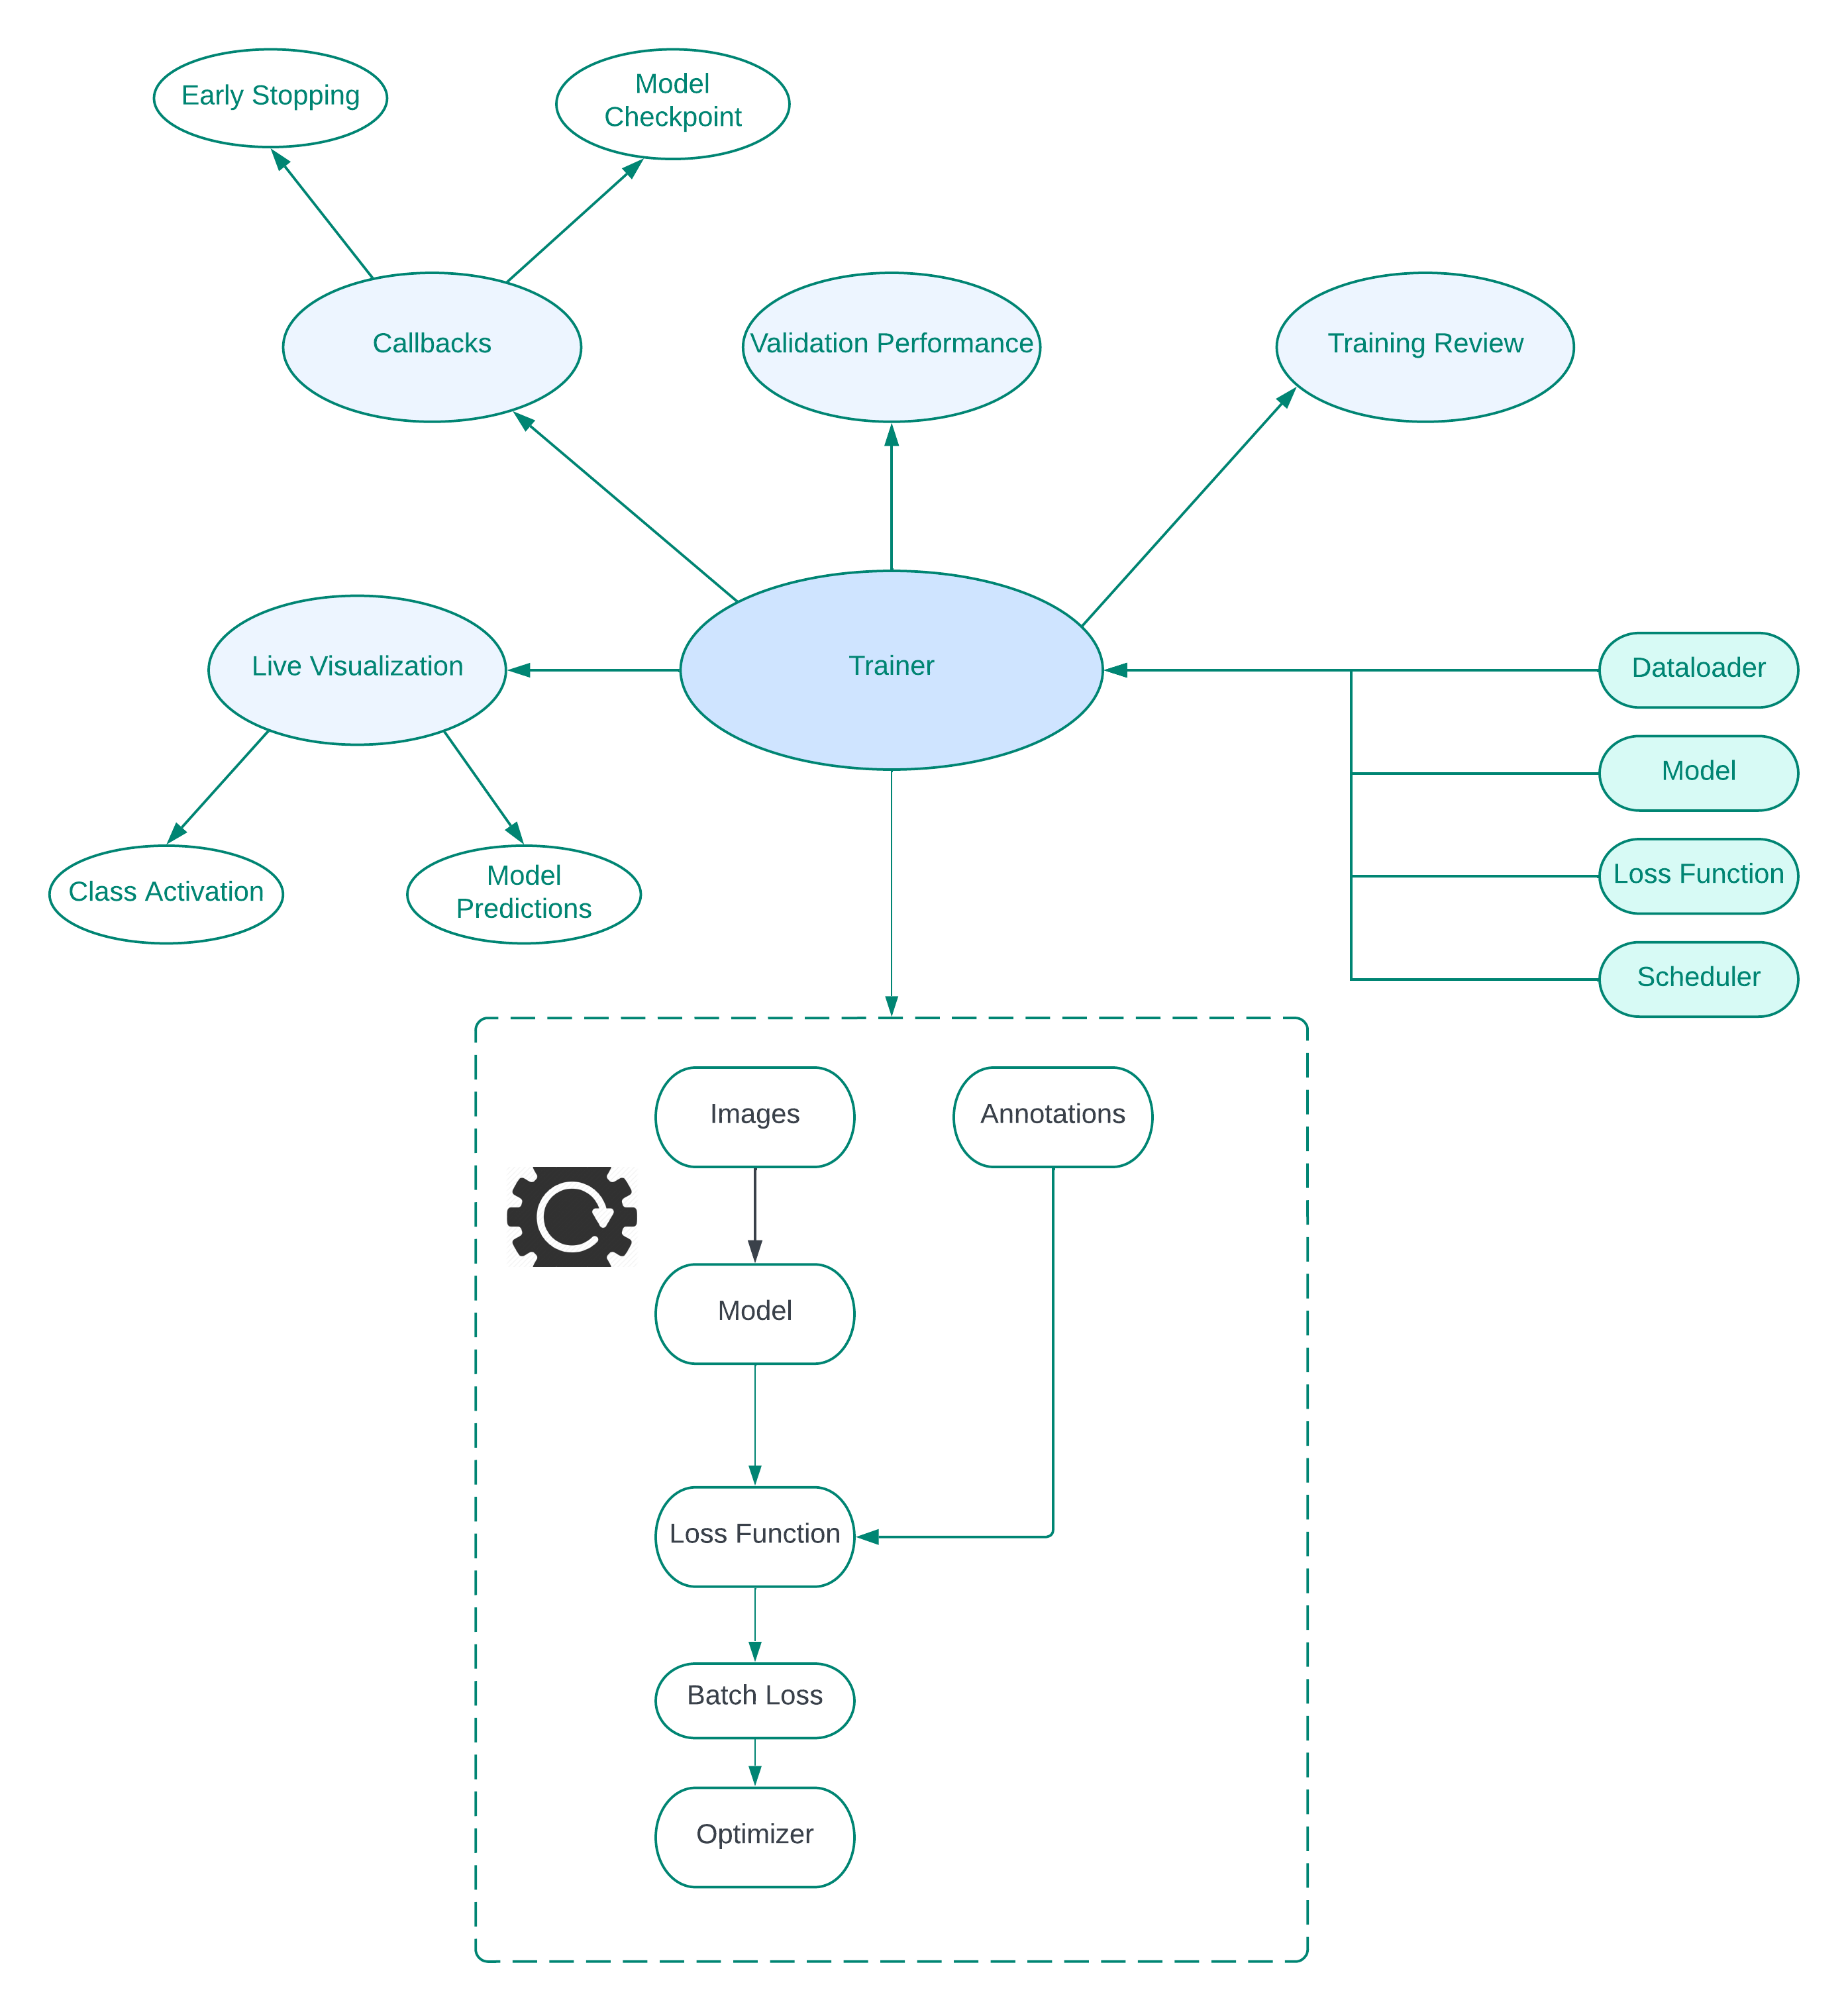

In [75]:
class Trainer:

    def __init__(self, network, train_dl, n_classes, epochs, loss_function, optimizer, scheduler=None, patience=None):

        self.network = network
        self.train_dl = train_dl
        self.epochs = epochs
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.scheduler = scheduler 
        #Initialize the early stopping mechanism
        self.dice = Dice(n_classes)
        if patience is not None:
            self.patience = patience
            self.best = float('inf') * -1
            self.counter = 0
            self.es = True
        else:
            self.es = False

        self.n_classes = n_classes
        self.multi = True if n_classes > 1 else False
    
    def early_stop(self, metric, mode=0):
        
        #mode=0 is for minimum, mode=1 is for maximum
        
        if mode:
            if metric > self.best:
                self.best = metric
                self.counter = 0
            else:
                self.counter += 1
        else:
            if metric < self.best:
                self.best = metric
                self.counter = 0
            else:
                self.counter += 1
        
        if self.counter > self.patience:
            return -1
        else:
            return 0

    
    def get_mins(self, seconds):
        
        """This function converts seconds to minutes and seconds"""

        return f"{math.floor(seconds // 60)} mins : {math.floor(seconds % 60)} seconds"
    
    def main_step(self, img_batch, target_batch, clf_loss, bcm_params):

        #Zeroing out previous gradients
        self.optimizer.zero_grad()

        #Make model prediction
        if clf_loss is None:
            pred = self.network(img_batch)
        else:
            pred = self.network(img_batch)
            
            clf_pred = f.max_pool2d(pred, pred.shape[2:])
            clf_pred = torch.squeeze(torch.squeeze(clf_pred, dim=-1), dim=-1)
            
            clf_target_batch = f.max_pool2d(target_batch, target_batch.shape[2:])
            clf_target_batch = torch.squeeze(torch.squeeze(clf_target_batch, dim=-1), dim=-1).float().to(device)
        
        target_batch = target_batch.float().to(device)
            
        #Compute Loss
        if clf_loss is None: 
            loss = self.loss_function(pred, target_batch)
        else:
            #Compute the loss for the multi-task training approach
            #(segmentation_prediction, segmentation_target), (classification_prediction, classification_target)
            loss = clf_loss((pred, target_batch), (clf_pred[:, 1:], clf_target_batch[:, 1:]))
        
        #Compute Binary Class Map Weighting
        if bcm_params is not None:
            pred = torch.softmax(pred, dim=1)
            class_index, bcm_loss_function = bcm_params
            class_map_pred = pred[:,class_index, :, :]
            class_map_target = target_batch[:, class_index, :, :]
            bcm_loss = bcm_loss_function(class_map_pred, class_map_target)

            loss = loss + bcm_loss
            
            
        #Calculate gradients through backpropagation
        loss.backward()            
        #Update the model parameters
        self.optimizer.step()
        
        return loss, pred
    
    def eval_step(self,img_batch, target_batch, clf_loss, bcm_params):
    
        #Assumes the network is already put into evaluation mode
        if clf_loss is None:
            val_pred = self.network(img_batch)
        else:
            #If it's multi-task training, then network will have 2 outputs. We have to handle that
            val_pred = self.network(img_batch)
            
            clf_pred = f.max_pool2d(val_pred, val_pred.shape[2:])
            clf_pred = torch.squeeze(torch.squeeze(clf_pred, dim=-1), dim=-1)
            
            clf_target_batch = f.max_pool2d(target_batch, target_batch.shape[2:])
            clf_target_batch = torch.squeeze(torch.squeeze(clf_target_batch, dim=-1), dim=-1).float().to(device)
            
        target_batch = target_batch.float().to(device)

        #Compute Loss
        if clf_loss is None:
            loss = self.loss_function(val_pred, target_batch)
        else:
            #Compute the loss for the multi-task training approach
            #(segmentation_prediction, segmentation_target), (classification_prediction, classification_target)
            loss = clf_loss((val_pred, target_batch), (clf_pred[:, 1:], clf_target_batch[:, 1:]))
        
        if bcm_params is not None:
            val_pred = torch.softmax(val_pred, dim=1)
            class_index, bcm_loss_function = bcm_params
            class_map_pred = val_pred[:,class_index, :, :]
            class_map_target = target_batch[:, class_index, :, :]
            bcm_loss = bcm_loss_function(class_map_pred, class_map_target)
            loss = loss + bcm_loss

        return loss, val_pred
    
    def plot_sample_prediction(self, img_batch, target_batch, pred_batch, ix, background=False):
    
        """This function plots along with a sample image and annotation, the prediction for the sample image
           background : is background included in the annotations
        """
        assert self.n_classes > 0
        multi = False if self.n_classes == 1 else True
        #Initializing the softmax and the sigmoid
        softmax = nn.Softmax(dim=0)
        sigmoid = nn.Sigmoid()
        
        fig, ax = plt.subplots(1,4, figsize=(8,4))

        #Getting an image and reshaping it
        test_img = img_batch[ix]
        #Removing the image from the gpu and the computation graph
        n_img = test_img.to('cpu').detach().numpy()
        n_img = np.transpose(n_img, (1,2,0))
        H = n_img.shape[0]
        W = n_img.shape[1]
        
        #Getting the corresponding annotation
        #For multi-class it will be (C,H,W)
        #Removing the annotation from the gpu and computation graph
        test_ann = target_batch[ix]
        n_ann = test_ann.to('cpu').detach().numpy()
        if multi:
        #Making channels last for a single annotation
            n_ann = np.rollaxis(n_ann, 0, 3)
        
        #Getting the corresponding prediction
        #For multi-class it will be (C,H,W)
        test_pred = pred_batch[ix]
        if multi:
            #applying the softmax function to the prediction since they are just scores
            test_pred = softmax(test_pred)
        else:
            #applying the sigmoid function to the prediction
            test_pred = sigmoid(test_pred)
        
        #Thresholded prediction
        threshold = torch.nn.Threshold(0.75, 0)
        test_pred_clamped = threshold(test_pred)
        #For multiclass it will be (C,W,H)
        n_pred = test_pred.to('cpu').detach().numpy()
        #n_pred = np.rollaxis(n_pred, 0, 3)
        
        #For multiclass it will be (C,W,H)
        n_pred_clamped = test_pred_clamped.to("cpu").detach().numpy()
        #n_pred_clamped = np.rollaxis(n_pred_clamped, 0, 3)
        
        
        #Creating masks that can be plotted
        if (not background) and multi:
            #This step creates a mask for the background and concatenates it to the front of the annotation and prediction
            #Then the argmax operation is performed to obtain a matrix which can be plotted
            
            bg = np.full((H,W, 1), 0.1)
            n_ann = np.concatenate([bg, n_ann], axis=-1)
            n_ann = np.argmax(n_ann, axis=-1)

            n_pred = np.concatenate([bg, n_pred], axis=0)
            n_pred = np.argmax(n_pred, axis=0)
            
            n_pred_clamped = np.concatenate([bg, n_pred_clamped], axis=0)
            n_pred_clamped = np.argmax(n_pred_clamped, axis=0)
            
            
        elif background and multi:
            
            n_ann = np.argmax(n_ann, axis=-1)
            n_pred = np.argmax(n_pred, axis=0)
            n_pred_clamped = np.argmax(n_pred_clamped, axis=0)
        else:
            
            #Squeeze the annotation and the prediction since imshow expects 3 channels or just a matrix
            n_ann = np.squeeze(n_ann)
            n_pred = np.squeeze(n_pred) 
            n_pred_clamped = np.squeeze(n_pred_clamped)
        

        #Plotting the image
        ax[0].imshow(n_img)
        ax[0].axis("off")
        #Plotting the annotation
        ax[1].imshow(n_ann)
        ax[1].axis("off")
        #Plotting the prediction
        ax[2].imshow(n_pred)
        ax[2].axis("off")
        #Plotting a thresholded prediction
        ax[3].imshow(n_pred_clamped)
        ax[3].axis("off")
        plt.show()

    def plot_class_activations(self, target_batch, pred_batch):
    
        """This function plots the individual class activations given a prediction image. 
        This function assumes that the channels are first.
        This function also assumes that no softmax has been applied
        """
        
        #Reminder -- Change the test pred to soft pred and uncomment the declaration
        
        softmax = nn.Softmax(dim=0)
        
        test_pred = pred_batch[0].detach().to("cpu")
        test_ann = target_batch[0].detach().to("cpu")
        
        soft_pred = softmax(test_pred)
        soft_pred = soft_pred.detach().to("cpu").numpy()
        
        fig, ax = plt.subplots(1, self.n_classes, figsize=(self.n_classes*2, self.n_classes))
        
        for i in range(self.n_classes):
            
            ax[i].imshow(test_ann[i])
            ax[i].axis("off")
        
        fig, ax2 = plt.subplots(1, self.n_classes, figsize=(self.n_classes*2,self.n_classes))
        
        for i in range(self.n_classes):

            ax2[i].imshow(soft_pred[i])
            ax2[i].axis("off")
        plt.show()
        
    def accuracy(self, predictions, target):
        """
        Computes the accuracy of the predictions against the true labels.
        """
        with torch.no_grad():
            pred = f.softmax(predictions, dim=1)
            pred_class = torch.argmax(pred, dim=1)
            target_class = torch.argmax(target, dim=1)
            correct = pred_class.eq(target_class).sum().item()
            acc = correct / len(target)
            return acc
        

    
    def loop_clf(self, current_epoch, valid_dl=None, metric_fn=None):
        
        loss_value = 0
        #Indicates start of batch
        total_batches = 0
        metric_val = 0 if metric_fn is not None else None
        
        if valid_dl is not None:
            train = False
            dl = valid_dl
            torch.set_grad_enabled(False)
            self.network.eval()
            loop_mode = "Validation"
        else:
            train = True
            dl = self.train_dl
            torch.set_grad_enabled(True)
            self.network.train()
            loop_mode = "Training"
                    
        for img_batch, target_batch in tqdm(dl):
                
            total_batches += 1
            #Putting the images on device
            img_batch = img_batch.to(device)
            target_batch = target_batch.to(device)
            #Obtaining the loss and the predictions for current batch - This is multiclass classification
            pred = self.network(img_batch)
                
            self.optimizer.zero_grad()
                
            loss = self.loss_function(pred, target_batch)
            if metric_fn is not None:
                metric_val += metric_fn(pred, target_batch)
            
            if train:
                #Calculate gradients through backpropagation if this is the training looop
                loss.backward()
                #Update the model parameters
                self.optimizer.step()
                
            loss_value += loss.item()
        
        loss_for_epoch = round(loss_value / total_batches, 3)
        print(f"{loop_mode} Loss at epoch : {current_epoch+1} : {loss_for_epoch}")
        
        if metric_fn is not None:
            metric_for_epoch = round(metric_val / total_batches, 3)
            print(f"{loop_mode} Metric at epoch : {current_epoch+1} : {metric_for_epoch}")
        
        return loss_for_epoch, metric_for_epoch
        
    def plot(self, e, training_losses, validation_losses):
        
        # Create a list of the epoch numbers
        epochs = range(1, e + 2)

        # Plot the training loss
        plt.plot(epochs, training_losses, 'r-', label='Training Loss', linewidth=2)

        # Plot the validation loss
        plt.plot(epochs, validation_losses, 'b--', label='Validation Loss', linewidth=2)

        # Set the title and labels
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')

        # Add a legend
        plt.legend()
        # Show the plot
        plt.show()
    
    def fit_classify(self, validation=False, valid_dl=None, model_checkpoint=True, model_save_path="./model_clf.pth"):
        
        training_losses = []
        validation_losses = []
        best_val_loss = float('inf')
        
        for e in range(self.epochs):
            print(f"Starting epoch : {e+1} -------------------------------------------------------------------")
            elapsed_time = 0
            st = time.time()            
            #Training Loop
            loss, metric = self.loop_clf(e, None, self.accuracy)
            training_losses.append(loss)
            
            if validation and valid_dl is not None:
                
                print("Running Validation Step")
                ########### Validation step ##########################################################################################                
                val_loss_for_epoch, val_metric = self.loop_clf(e, valid_dl, self.accuracy)
                validation_losses.append(val_loss_for_epoch)
                
                #Model Checkpoint
                if val_loss_for_epoch < best_val_loss and model_checkpoint:
                    best_val_loss = val_loss_for_epoch
                    torch.save(self.network.state_dict(), model_save_path)
                    print(f"Saved model at val dice : {best_val_loss}")
                
                
                #Early Stopping
                if self.es:
                    #Return value of the early stop
                    rv = self.early_stop(val_loss_for_epoch, mode=0)
                    if rv == -1:
                        print(f"Early Stopping kicked in : Stopping at epoch {e+1}")
                        break
                
                #Modifying learning rate
                if self.scheduler is not None:
                    self.scheduler.step(val_loss_for_epoch)
                    
                
                
            #End of Epoch ----------------------------------------------------------------------------------------------------------------------=
            #Calculate the end time and log
            et = time.time()
            elapsed_time = et - st
            print(f"Epoch : {e+1} took {self.get_mins(elapsed_time)}")
            print("\n")
                
            ######### End of validation step #######
            print("------------------------------------------------------------------------------------------")
            print("\n")
            print("\n")
            print("\n")
        
        if not model_checkpoint:
            torch.save(self.network.state_dict(), model_save_path)
        
        self.plot(e, training_losses, validation_losses)

        


    def fit(self, log=True, validation=False, valid_dl=None, model_checkpoint=True, clf_loss=None, bcm_params=None,model_save_path="./model.pth"):
        
        training_losses = []
        validation_losses = []
        best_val_loss = float('inf') * -1.0

        for e in range(self.epochs):
            print(f"Starting epoch : {e+1} -------------------------------------------------------------------")
            elapsed_time = 0
            st = time.time()
            loss_value = 0
            
            #Indicates start of batch
            start = True
            start_2 = True
            total_batches = 0
            
            #Training Loop
            self.network.train()
            for img_batch, annotation_batch in self.train_dl:
                
                total_batches += 1
                #Putting the images and annotations on the device
                img_batch = img_batch.to(device)
                #Obtaining the loss and the predictions for current batch - This is multiclass classification

                loss, pred = self.main_step(img_batch, annotation_batch, clf_loss, bcm_params)
            
                #Check for the start of the batch to visualize a prediction
                if start:
                    self.plot_sample_prediction(img_batch, annotation_batch, pred, 0, background=True)
                    #Indicate that next batch is not start of epoch
                    if self.multi:
                        print(f"Plotting Activations")
                        self.plot_class_activations(annotation_batch.to(device), pred)
                    start = False
                
                #Updating loss by adding loss for current batch  
                loss_value += loss.item()
                if start_2:
                    print(f"The loss on the first batch is : {loss_value}")
                    start_2 = False
            
            #If logging is enabled print total loss value for the epoch divided by batch size
            if log:
                loss_for_epoch = round(loss_value / total_batches, 3)
                training_losses.append(loss_for_epoch)
                print(f"Loss at epoch : {e+1} : {loss_for_epoch}")

            
            #Validation Loop
            ######################################################################################################################################

            if validation and valid_dl is not None:

                print("Running Validation Step")
                ######### Validation step ############
                val_loss = 0
                val_dice_score = 0
                val_start = True
                val_start_2 = True
                val_batches = 0
                with torch.no_grad():
                    self.network.eval()

                    for img_batch, annotation_batch in valid_dl:
                        
                        val_batches += 1
                        val_img_batch = img_batch.to(device)
                        
                        valid_loss, val_pred = self.eval_step(val_img_batch, annotation_batch, clf_loss, bcm_params)
                        #Compute the dice metric
                        val_dice_score += self.dice(val_pred, annotation_batch.float().to(device)).item()
                        
                        if val_start:
                            self.plot_sample_prediction(val_img_batch, annotation_batch, val_pred, 0, background=True)
                            val_start = False

                        val_loss += valid_loss.item()

                        if val_start_2:
                            print(f"The loss on the first batch for validation is : {val_loss}")
                            val_start_2 = False


                #If logging is enabled print total loss value for the epoch divided by batch size
                if log:
                    val_loss_for_epoch = round(val_loss / val_batches, 3)
                    val_dice_for_epoch = round(val_dice_score / val_batches, 3)
                    validation_losses.append(val_loss_for_epoch)
                    print(f"Validation Loss at epoch : {e+1} : {val_loss_for_epoch}")
                    print(f"Validation Dice Score at epoch : {e+1} : {val_dice_for_epoch}")
                
                # Saving the best version of the model
                if val_dice_for_epoch > best_val_loss and model_checkpoint:
                    best_val_loss = val_dice_for_epoch
                    torch.save(self.network.state_dict(), model_save_path)
                    print(f"Saved model at val dice : {best_val_loss}")
                
                
                #Early Stopping
                if self.es:
                    #Early stop if dice validation is less than the max
                    #Return value of the early stop
                    rv = self.early_stop(val_dice_for_epoch, mode=1)
                    if rv == -1:
                        print(f"Early Stopping kicked in : Stopping at epoch {e+1}")
                        break
                
                #Modifying learning rate
                if self.scheduler is not None:
                    self.scheduler.step(val_dice_for_epoch)

                
            #End of Epoch -----------------------------------------------------------------------------------------------------------------------
            #Calculate the end time and log
            et = time.time()
            elapsed_time = et - st
            print(f"Epoch : {e+1} took {self.get_mins(elapsed_time)}")
            print("\n")
                
            ######### End of validation step #######
            print("------------------------------------------------------------------------------------------")
            print("\n")
            print("\n")
            print("\n")
        
        if not model_checkpoint:
            torch.save(self.network.state_dict(), model_save_path)

        # Create a list of the epoch numbers
        epochs = range(1, e + 2)

        # Plot the training loss
        plt.plot(epochs, training_losses, 'r-', label='Training Loss', linewidth=2)

        # Plot the validation loss
        plt.plot(epochs, validation_losses, 'b--', label='Validation Loss', linewidth=2)

        # Set the title and labels
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')

        # Add a legend
        plt.legend()
        # Show the plot
        plt.show()
    
    

## Model Training

In [ ]:
res_unet = ResNetUNet(5, simple=True, attention=0).to(device)

In [ ]:
pos_weight = torch.Tensor([1, 35, 7, 5, 12]).to(device)
#seg_loss_function = CrossEntropy4D(class_weights=pos_weight)
#seg_loss_function = DiceLoss(num_classes=5)
seg_loss_function = DiceCE(5)
#seg_loss_function = CompoundLoss(l1=False, lamb=0.1)
#seg_loss_function = WeightedCrossEntropy(class_weights=pos_weight)
#clf_loss_function = DiceCLFLoss()
clf_loss_function = MultiLabelBCEWithLogitsLoss()
loss_function = MultiTaskLoss(seg_loss=seg_loss_function, clf_loss=clf_loss_function)
#loss_function = DiceLoss(num_classes=5)
#loss_function = DiceCE(num_classes=5, class_weights=pos_weight)
optimizer = torch.optim.Adam(res_unet.parameters(), lr=1.5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)

In [ ]:
trainer = Trainer(res_unet, train_dl, 5,50, loss_function, optimizer, scheduler, patience=5)

Starting epoch : 1 -------------------------------------------------------------------


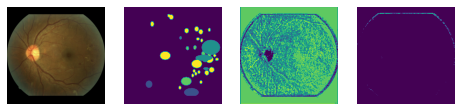

Plotting Activations


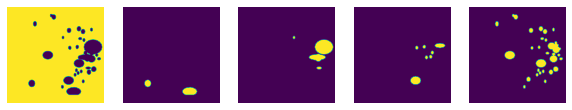

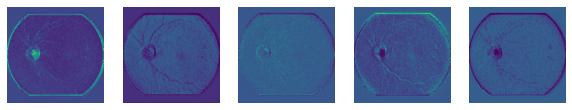

The loss on the first batch is : 3.1990270614624023
Loss at epoch : 1 : 2.149
Running Validation Step


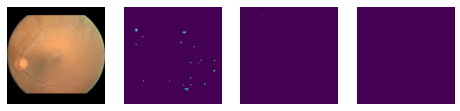

The loss on the first batch for validation is : 1.7326886653900146
Validation Loss at epoch : 1 : 1.683
Validation Dice Score at epoch : 1 : 0.198
Saved model at val dice : 0.198
Epoch : 1 took 2 mins : 40 seconds


------------------------------------------------------------------------------------------






Starting epoch : 2 -------------------------------------------------------------------


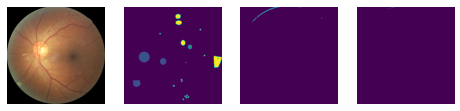

Plotting Activations


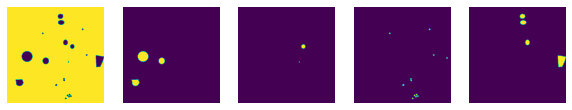

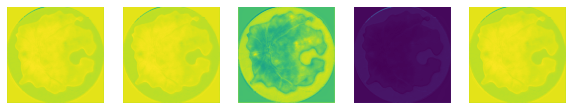

The loss on the first batch is : 2.1757335662841797
Loss at epoch : 2 : 1.718
Running Validation Step


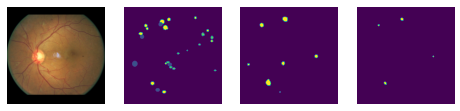

The loss on the first batch for validation is : 1.4223804473876953
Validation Loss at epoch : 2 : 1.478
Validation Dice Score at epoch : 2 : 0.239
Saved model at val dice : 0.239
Epoch : 2 took 2 mins : 41 seconds


------------------------------------------------------------------------------------------






Starting epoch : 3 -------------------------------------------------------------------


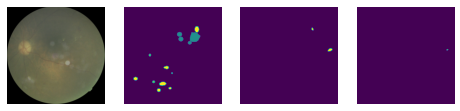

Plotting Activations


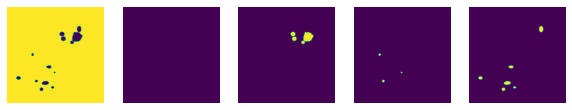

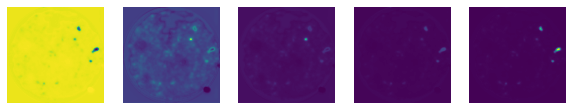

The loss on the first batch is : 1.5184886455535889
Loss at epoch : 3 : 1.604
Running Validation Step


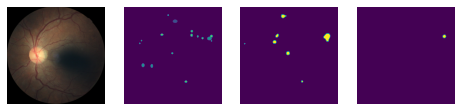

The loss on the first batch for validation is : 1.4695792198181152
Validation Loss at epoch : 3 : 1.412
Validation Dice Score at epoch : 3 : 0.27
Saved model at val dice : 0.27
Epoch : 3 took 2 mins : 41 seconds


------------------------------------------------------------------------------------------






Starting epoch : 4 -------------------------------------------------------------------


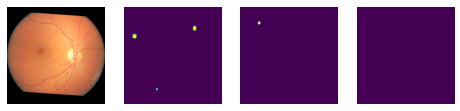

Plotting Activations


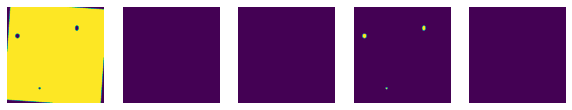

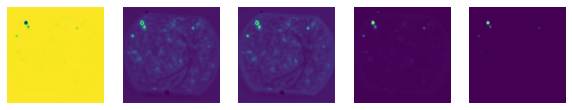

The loss on the first batch is : 1.3960201740264893
Loss at epoch : 4 : 1.569
Running Validation Step


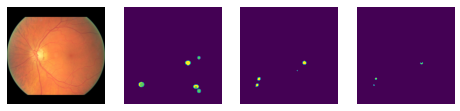

The loss on the first batch for validation is : 1.3479368686676025
Validation Loss at epoch : 4 : 1.362
Validation Dice Score at epoch : 4 : 0.304
Saved model at val dice : 0.304
Epoch : 4 took 2 mins : 41 seconds


------------------------------------------------------------------------------------------






Starting epoch : 5 -------------------------------------------------------------------


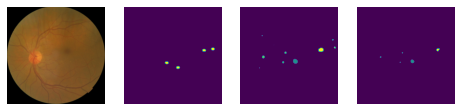

Plotting Activations


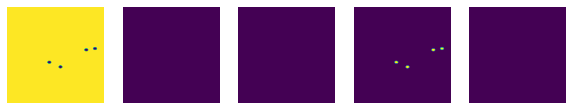

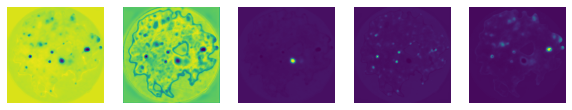

The loss on the first batch is : 1.868204116821289
Loss at epoch : 5 : 1.522
Running Validation Step


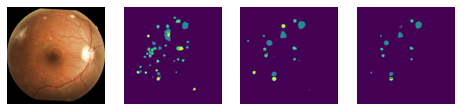

The loss on the first batch for validation is : 1.1966099739074707
Validation Loss at epoch : 5 : 1.342
Validation Dice Score at epoch : 5 : 0.315
Saved model at val dice : 0.315
Epoch : 5 took 2 mins : 41 seconds


------------------------------------------------------------------------------------------






Starting epoch : 6 -------------------------------------------------------------------


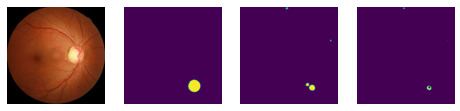

Plotting Activations


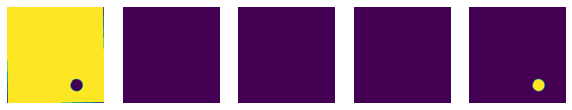

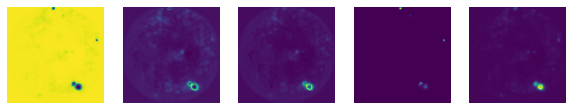

The loss on the first batch is : 1.4512913227081299
Loss at epoch : 6 : 1.516
Running Validation Step


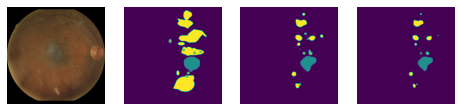

The loss on the first batch for validation is : 1.3658766746520996
Validation Loss at epoch : 6 : 1.323
Validation Dice Score at epoch : 6 : 0.332
Saved model at val dice : 0.332
Epoch : 6 took 2 mins : 42 seconds


------------------------------------------------------------------------------------------






Starting epoch : 7 -------------------------------------------------------------------


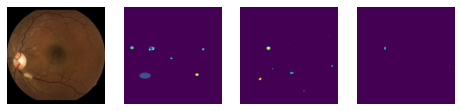

Plotting Activations


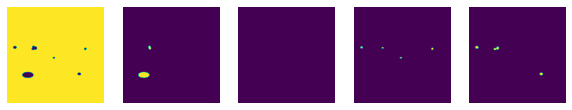

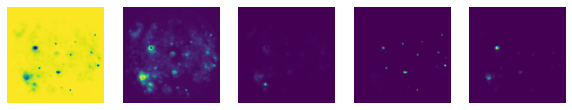

The loss on the first batch is : 1.2867897748947144
Loss at epoch : 7 : 1.503
Running Validation Step


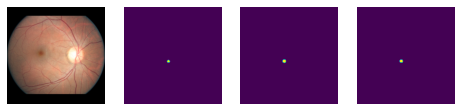

The loss on the first batch for validation is : 1.2663899660110474
Validation Loss at epoch : 7 : 1.33
Validation Dice Score at epoch : 7 : 0.331
Epoch : 7 took 2 mins : 41 seconds


------------------------------------------------------------------------------------------






Starting epoch : 8 -------------------------------------------------------------------


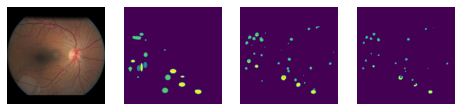

Plotting Activations


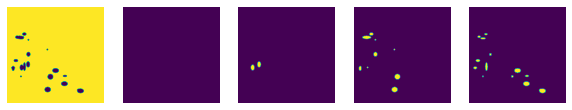

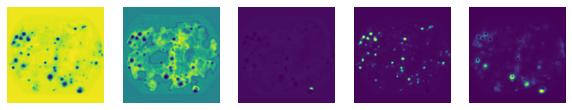

The loss on the first batch is : 1.3200304508209229
Loss at epoch : 8 : 1.489
Running Validation Step


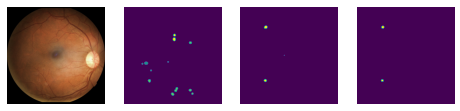

The loss on the first batch for validation is : 1.2067660093307495
Validation Loss at epoch : 8 : 1.312
Validation Dice Score at epoch : 8 : 0.339
Saved model at val dice : 0.339
Epoch : 8 took 2 mins : 41 seconds


------------------------------------------------------------------------------------------






Starting epoch : 9 -------------------------------------------------------------------


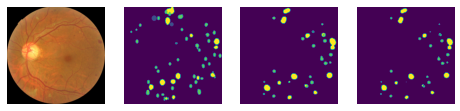

Plotting Activations


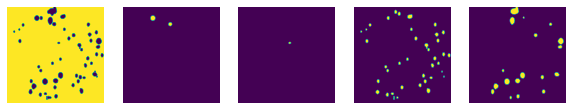

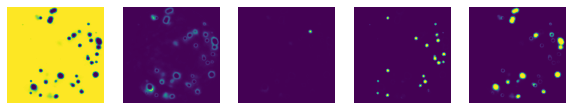

The loss on the first batch is : 1.9338210821151733
Loss at epoch : 9 : 1.486
Running Validation Step


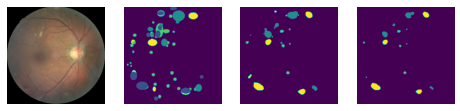

The loss on the first batch for validation is : 1.226290225982666
Validation Loss at epoch : 9 : 1.317
Validation Dice Score at epoch : 9 : 0.333
Epoch : 9 took 2 mins : 42 seconds


------------------------------------------------------------------------------------------






Starting epoch : 10 -------------------------------------------------------------------


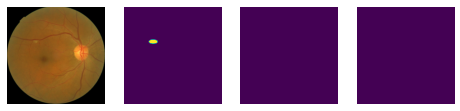

Plotting Activations


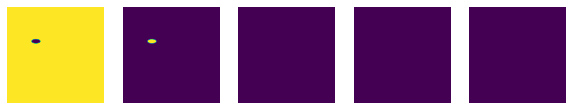

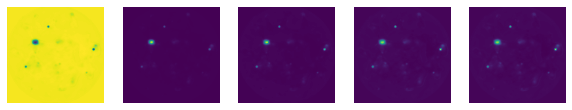

The loss on the first batch is : 1.3228175640106201
Loss at epoch : 10 : 1.474
Running Validation Step


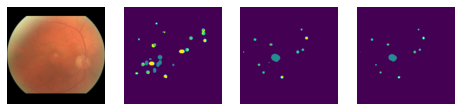

The loss on the first batch for validation is : 1.3005766868591309
Validation Loss at epoch : 10 : 1.318
Validation Dice Score at epoch : 10 : 0.34
Saved model at val dice : 0.34
Epoch : 10 took 2 mins : 41 seconds


------------------------------------------------------------------------------------------






Starting epoch : 11 -------------------------------------------------------------------


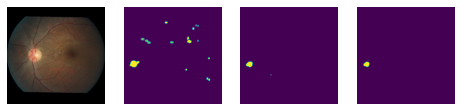

Plotting Activations


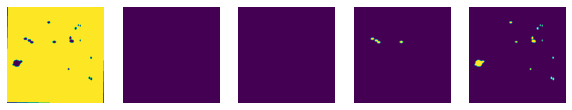

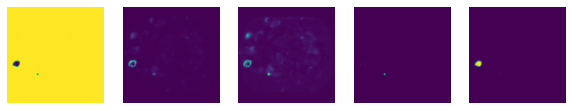

The loss on the first batch is : 1.5148966312408447
Loss at epoch : 11 : 1.465
Running Validation Step


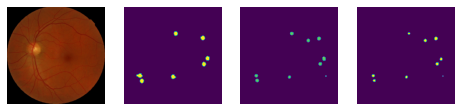

The loss on the first batch for validation is : 1.294706106185913
Validation Loss at epoch : 11 : 1.305
Validation Dice Score at epoch : 11 : 0.343
Saved model at val dice : 0.343
Epoch : 11 took 2 mins : 41 seconds


------------------------------------------------------------------------------------------






Starting epoch : 12 -------------------------------------------------------------------


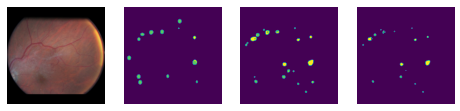

Plotting Activations


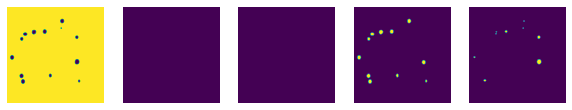

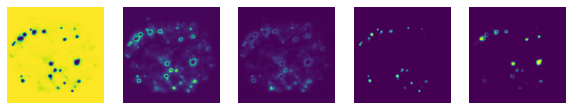

The loss on the first batch is : 1.4141145944595337
Loss at epoch : 12 : 1.447
Running Validation Step


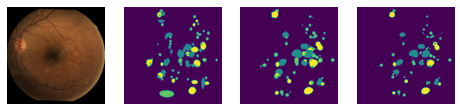

The loss on the first batch for validation is : 1.348672866821289
Validation Loss at epoch : 12 : 1.295
Validation Dice Score at epoch : 12 : 0.347
Saved model at val dice : 0.347
Epoch : 12 took 2 mins : 42 seconds


------------------------------------------------------------------------------------------






Starting epoch : 13 -------------------------------------------------------------------


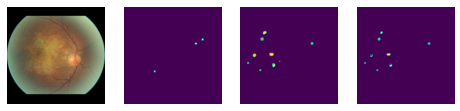

Plotting Activations


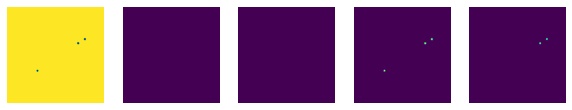

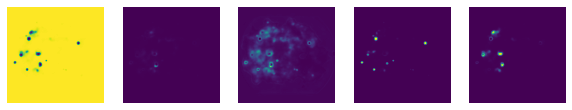

The loss on the first batch is : 1.3366448879241943
Loss at epoch : 13 : 1.46
Running Validation Step


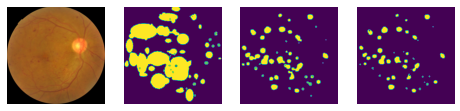

The loss on the first batch for validation is : 1.5012151002883911
Validation Loss at epoch : 13 : 1.295
Validation Dice Score at epoch : 13 : 0.361
Saved model at val dice : 0.361
Epoch : 13 took 2 mins : 41 seconds


------------------------------------------------------------------------------------------






Starting epoch : 14 -------------------------------------------------------------------


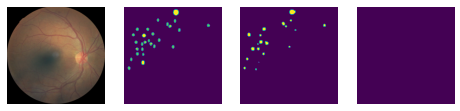

Plotting Activations


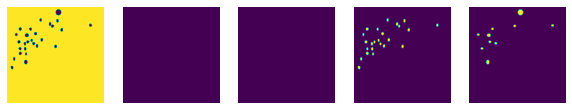

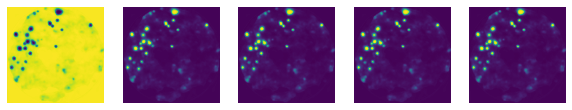

The loss on the first batch is : 1.611617088317871
Loss at epoch : 14 : 1.453
Running Validation Step


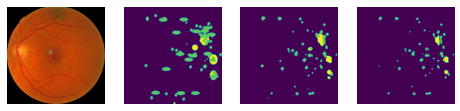

The loss on the first batch for validation is : 1.2047942876815796
Validation Loss at epoch : 14 : 1.288
Validation Dice Score at epoch : 14 : 0.358
Epoch : 14 took 2 mins : 41 seconds


------------------------------------------------------------------------------------------






Starting epoch : 15 -------------------------------------------------------------------


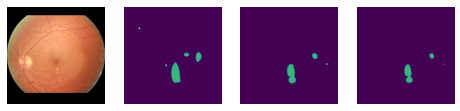

Plotting Activations


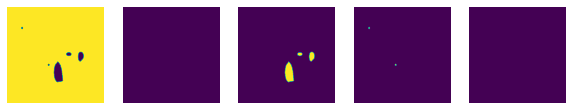

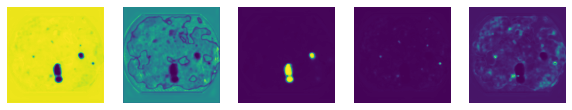

The loss on the first batch is : 1.4395092725753784
Loss at epoch : 15 : 1.431
Running Validation Step


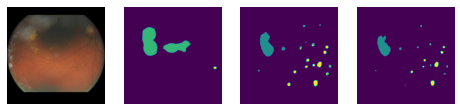

The loss on the first batch for validation is : 1.2614068984985352
Validation Loss at epoch : 15 : 1.284
Validation Dice Score at epoch : 15 : 0.36
Epoch : 15 took 2 mins : 41 seconds


------------------------------------------------------------------------------------------






Starting epoch : 16 -------------------------------------------------------------------


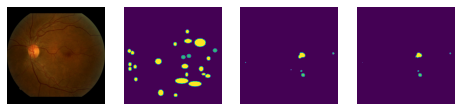

Plotting Activations


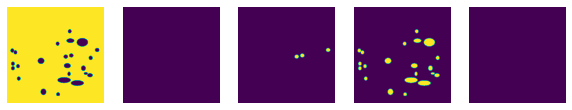

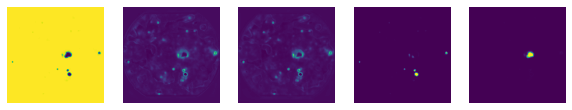

The loss on the first batch is : 1.585229754447937
Loss at epoch : 16 : 1.434
Running Validation Step


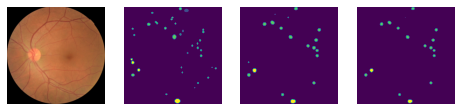

The loss on the first batch for validation is : 1.1673343181610107
Validation Loss at epoch : 16 : 1.284
Validation Dice Score at epoch : 16 : 0.358
Epoch : 16 took 2 mins : 41 seconds


------------------------------------------------------------------------------------------






Starting epoch : 17 -------------------------------------------------------------------


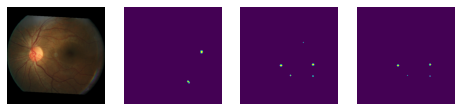

Plotting Activations


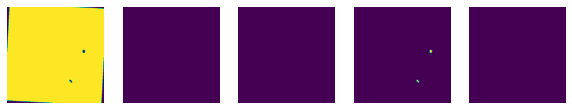

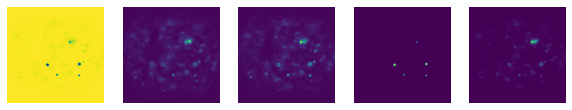

The loss on the first batch is : 1.4597501754760742
Loss at epoch : 17 : 1.431
Running Validation Step


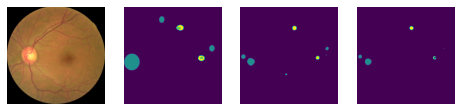

The loss on the first batch for validation is : 1.2377164363861084
Validation Loss at epoch : 17 : 1.269
Validation Dice Score at epoch : 17 : 0.367
Saved model at val dice : 0.367
Epoch : 17 took 2 mins : 48 seconds


------------------------------------------------------------------------------------------






Starting epoch : 18 -------------------------------------------------------------------


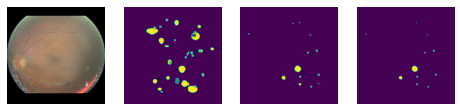

Plotting Activations


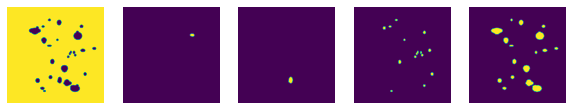

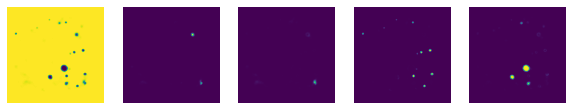

The loss on the first batch is : 1.2237237691879272
Loss at epoch : 18 : 1.426
Running Validation Step


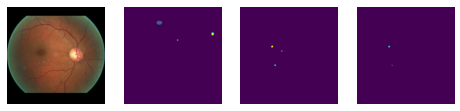

The loss on the first batch for validation is : 1.190544843673706
Validation Loss at epoch : 18 : 1.275
Validation Dice Score at epoch : 18 : 0.366
Epoch : 18 took 2 mins : 41 seconds


------------------------------------------------------------------------------------------






Starting epoch : 19 -------------------------------------------------------------------


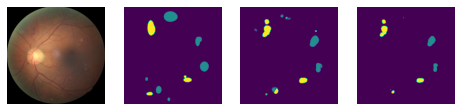

Plotting Activations


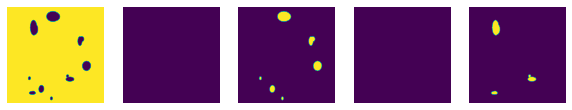

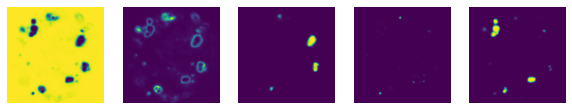

The loss on the first batch is : 1.7826619148254395
Loss at epoch : 19 : 1.426
Running Validation Step


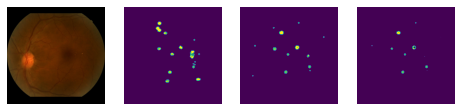

The loss on the first batch for validation is : 1.2917652130126953
Validation Loss at epoch : 19 : 1.279
Validation Dice Score at epoch : 19 : 0.359
Epoch : 19 took 2 mins : 41 seconds


------------------------------------------------------------------------------------------






Starting epoch : 20 -------------------------------------------------------------------


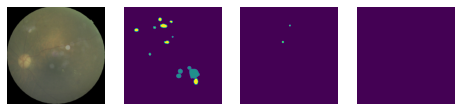

Plotting Activations


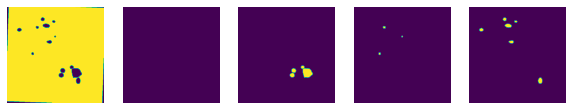

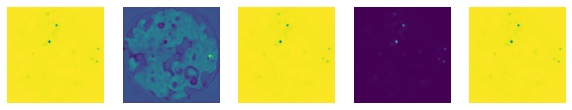

The loss on the first batch is : 1.4957249164581299
Loss at epoch : 20 : 1.407
Running Validation Step


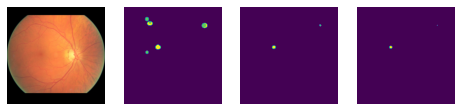

The loss on the first batch for validation is : 1.3053748607635498
Validation Loss at epoch : 20 : 1.287
Validation Dice Score at epoch : 20 : 0.354
Epoch : 20 took 2 mins : 41 seconds


------------------------------------------------------------------------------------------






Starting epoch : 21 -------------------------------------------------------------------


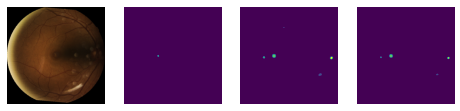

Plotting Activations


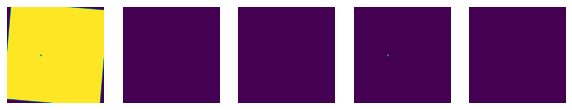

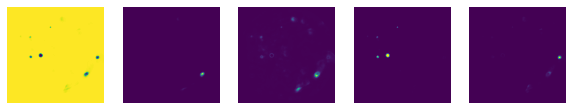

The loss on the first batch is : 1.254837155342102
Loss at epoch : 21 : 1.434
Running Validation Step


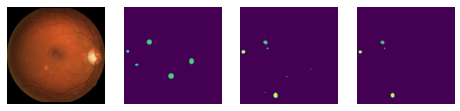

The loss on the first batch for validation is : 1.1570377349853516
Validation Loss at epoch : 21 : 1.276
Validation Dice Score at epoch : 21 : 0.365
Epoch : 21 took 2 mins : 41 seconds


------------------------------------------------------------------------------------------






Starting epoch : 22 -------------------------------------------------------------------


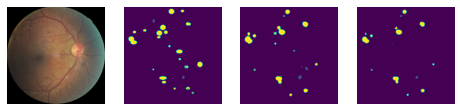

Plotting Activations


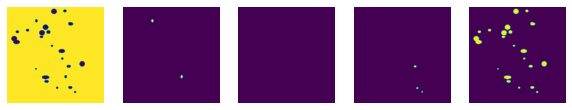

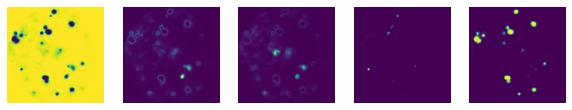

The loss on the first batch is : 1.1691193580627441
Loss at epoch : 22 : 1.423
Running Validation Step


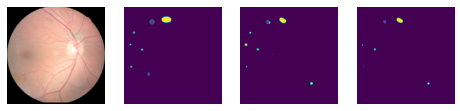

The loss on the first batch for validation is : 1.1656756401062012
Validation Loss at epoch : 22 : 1.278
Validation Dice Score at epoch : 22 : 0.363
Epoch : 22 took 2 mins : 41 seconds


------------------------------------------------------------------------------------------






Starting epoch : 23 -------------------------------------------------------------------


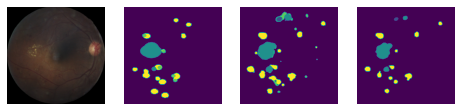

Plotting Activations


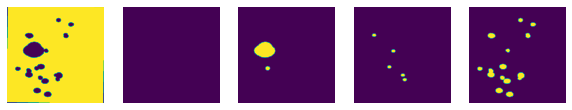

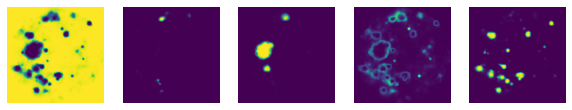

The loss on the first batch is : 1.2494299411773682
Loss at epoch : 23 : 1.435
Running Validation Step


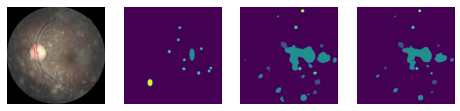

The loss on the first batch for validation is : 1.2484560012817383
Validation Loss at epoch : 23 : 1.269
Validation Dice Score at epoch : 23 : 0.364
Early Stopping kicked in : Stopping at epoch 23


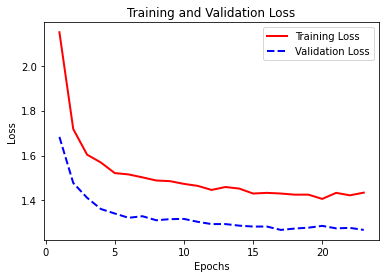

In [111]:
trainer.fit(log=True, validation=True, valid_dl=valid_dl, model_checkpoint=True,clf_loss=loss_function,model_save_path="./model_weights/stage_5/mtt_resnet_bce.pth")


## Evaluation

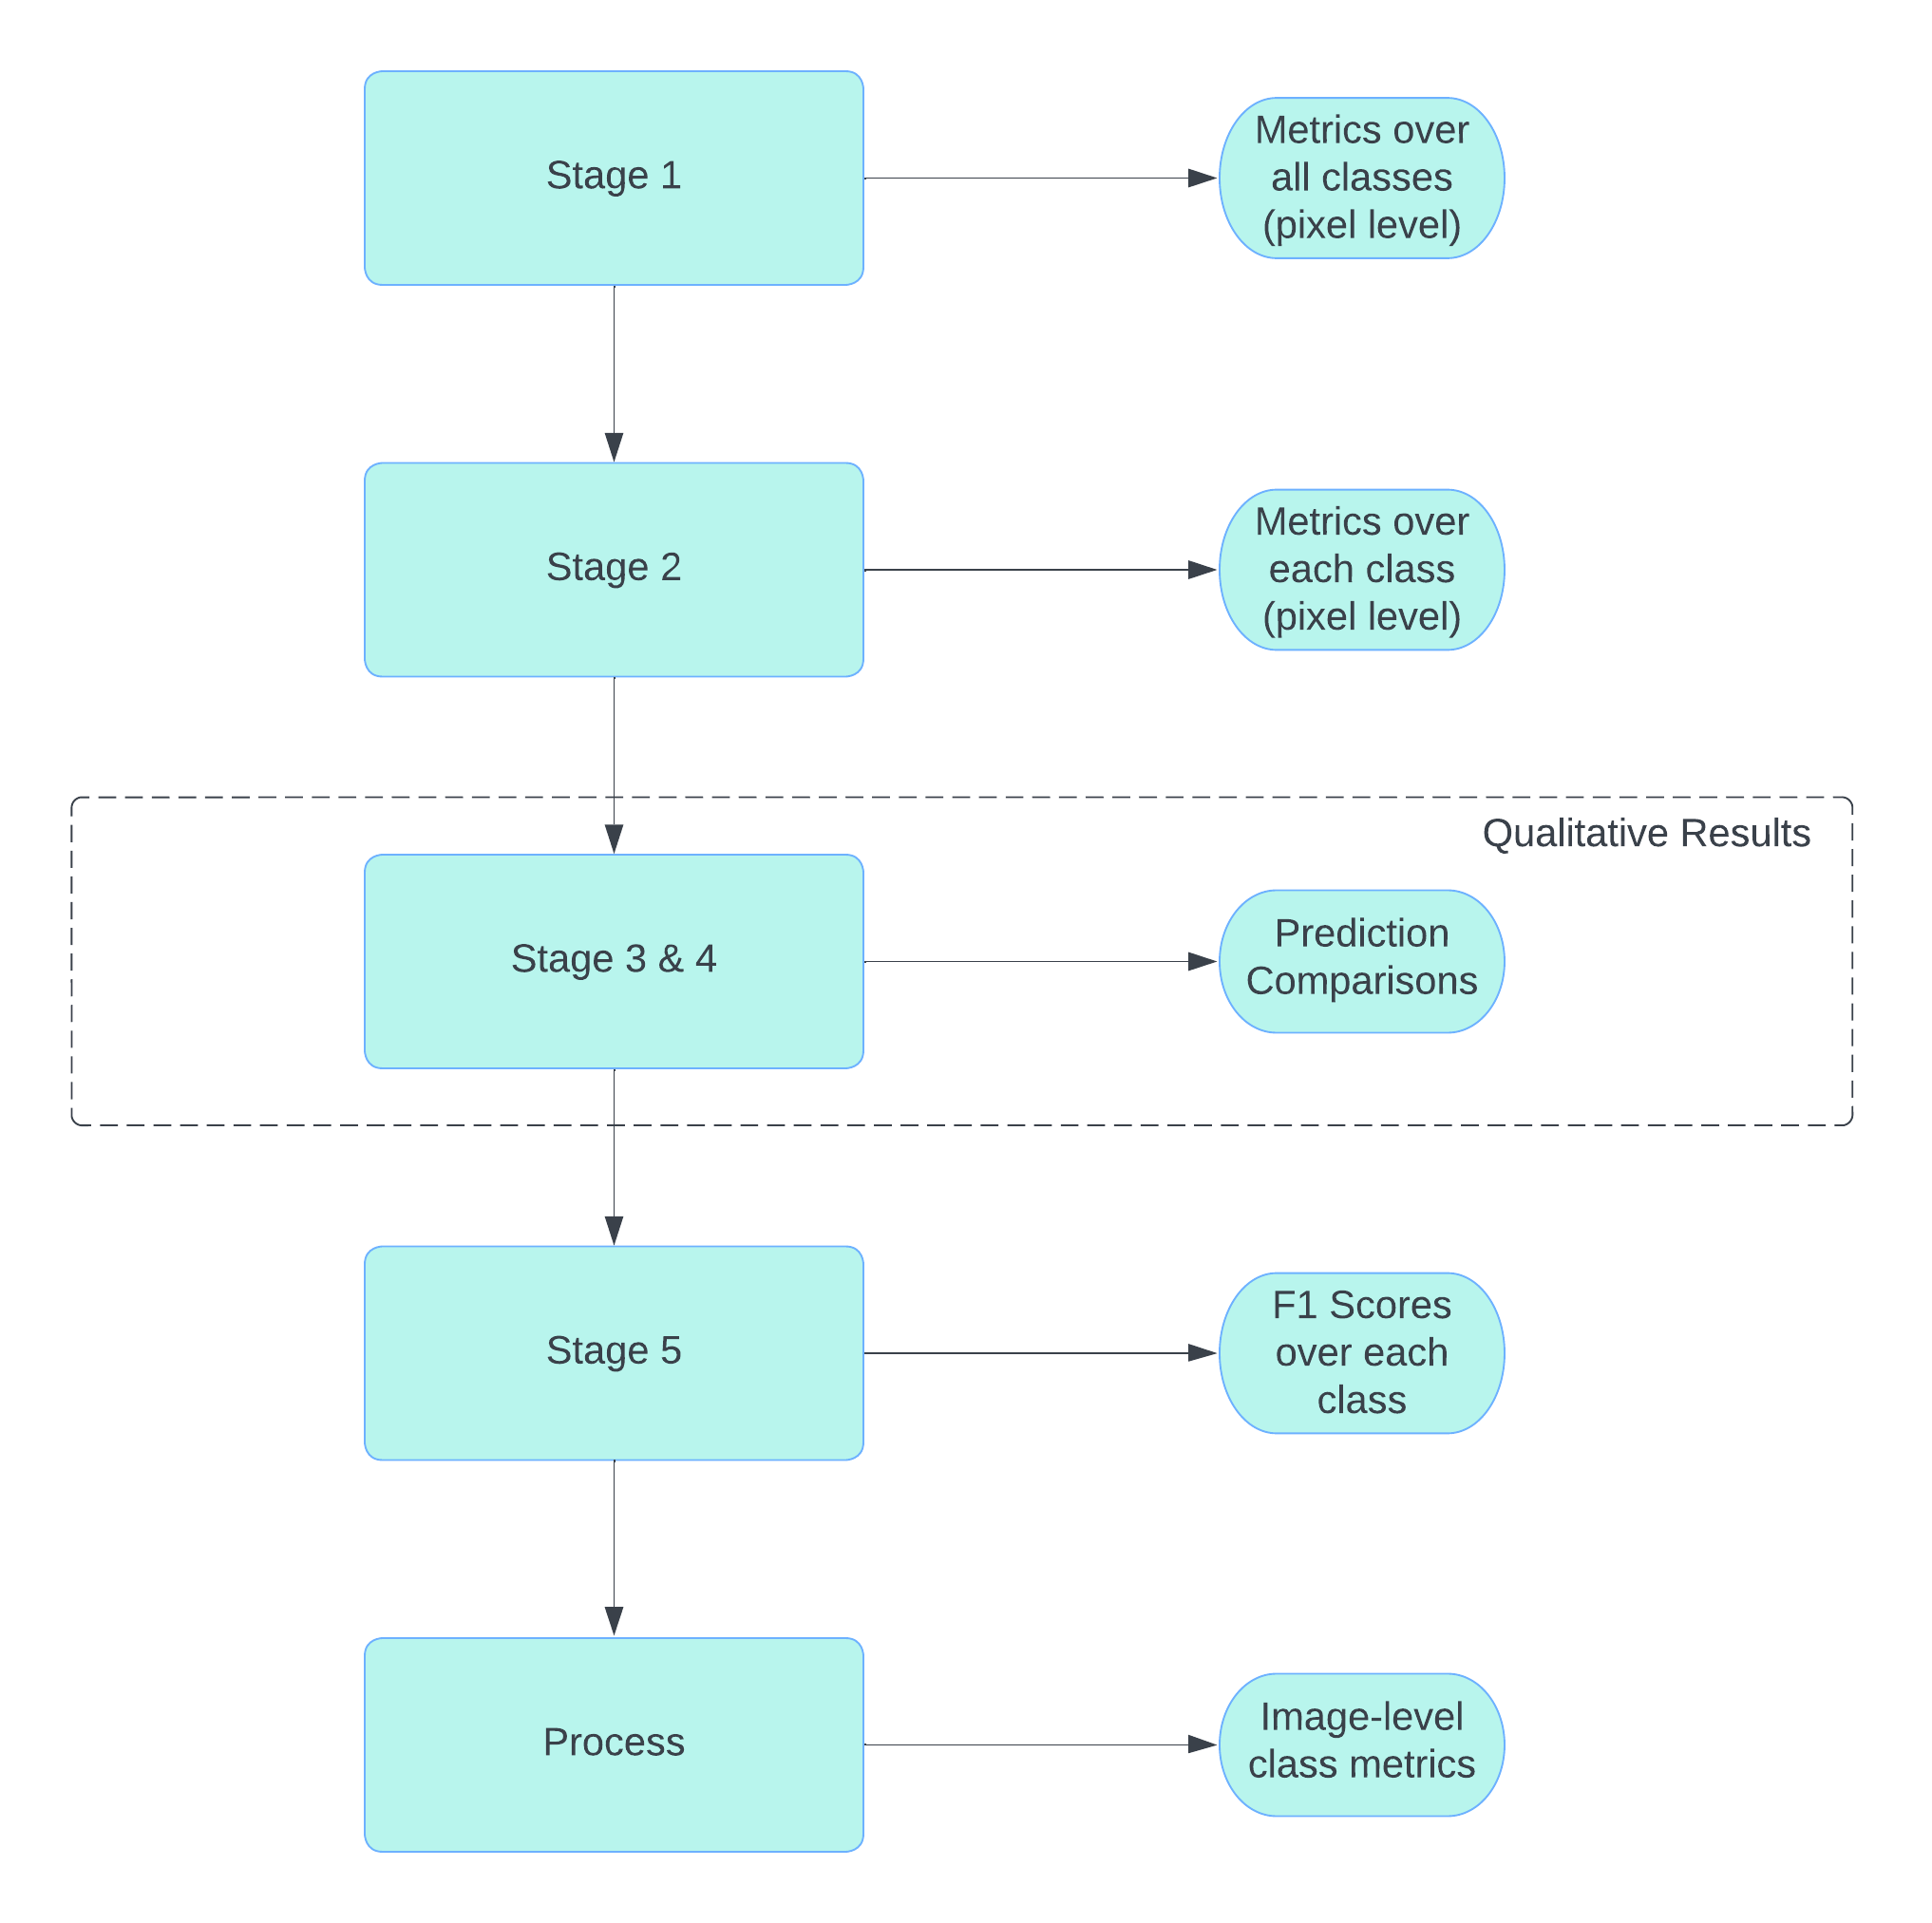

In [146]:
import json
class EvalPipeline:
    
    def __init__(self, dataloader, n,model_dict, class_dict, color_dict):
        
        """"This is an evaluation pipeline which can be used to determine the evaluation metrics for a group of segmentation models."""

        self.dl = dataloader
        self.img, self.gt = zip(*[(data[0].numpy(), data[1].numpy()) for data in dataloader])
        self.img = np.concatenate(self.img)
        #For the methods defined below, the ground-truths need to be in the following shape : (B, H, W, 1)
        self.gt = np.concatenate(self.gt)
            
        self.clf_gt = torch.from_numpy(self.gt)
        self.clf_gt = f.max_pool2d(self.clf_gt, self.clf_gt.shape[2:])
        self.clf_gt = torch.squeeze(torch.squeeze(self.clf_gt, dim=-1), dim=-1).to(torch.int)
        
        self.gt = np.transpose(self.gt, (0, 2, 3, 1))
        self.gt = np.argmax(self.gt, axis=3)
        self.gt = np.expand_dims(self.gt, axis=-1)
        
        self.model_dict = model_dict
        self.n = n
        self.class_dict = class_dict
        self.color_dict = color_dict
        self.prediction_gen()
        
    def prediction_gen(self):

        """Generates predictions for each segmentation model"""
        
        predictions = {}
        profiles = {}
        
        for m in self.model_dict.keys():
            model = self.model_dict[m]

            #For the methods below, the predictions need to be in the following shape : (B, H, W, 1)
            pred = model.predict(self.dl)
            
            #Getting the lesion profiles from predictions
            profile = torch.from_numpy(pred)
            profile = profile.permute(0,3,1,2)
            clf_pred = f.max_pool2d(profile, profile.shape[2:])
            clf_pred = torch.squeeze(torch.squeeze(clf_pred, dim=-1), dim=-1)
            clf_pred = torch.round(clf_pred).to(torch.int)
            
            profiles[m] = clf_pred
            
            pred = np.argmax(pred, axis=-1)
            pred = np.expand_dims(pred, axis=-1)
            
            predictions[m] = pred
            
        self.pred = predictions
        self.clf_preds = profiles
    
    def exact_match_ratio(self, predictions, targets, threshold=0.5):
        """
        :param predictions: tensor of shape (batch_size, num_classes) with predicted scores
        :param targets: tensor of shape (batch_size, num_classes) with target scores
        :return: exact match ratio
        """
        # binarize predictions using threshold
        binary_predictions = torch.where(predictions > threshold, 1, 0)
        # calculate element-wise equality between binary predictions and targets
        equality = torch.eq(binary_predictions, targets)
        # calculate row-wise sums of element-wise equality
        row_sums = torch.sum(equality, dim=1)
        # calculate exact match ratio
        exact_match_ratio = torch.mean(torch.eq(row_sums, targets.shape[1]).float())
        return exact_match_ratio
    
    def jaccard(self, predictions, targets, threshold=0.5):

        binary_predictions = torch.where(predictions > threshold, 1, 0)
        #Calculate the intersection between predictions and targets, sum in the class dimension
        intersection = torch.sum(binary_predictions * targets, dim=1)
        union = torch.sum((binary_predictions | targets), dim=1)

        jaccard_score = torch.mean(intersection.float() / union.float())
        return jaccard_score
    #This function swaps colors from a class map
    def color_swap(self, img):
    
        for key in self.color_dict.keys():

            c = np.where(img[:, :, [0,1,2]] == [key, key, key])
            img[c[0], c[1], :] = self.color_dict[key]

        return img
    
    def image_overlay(self, img, ann):
        
        """This function overlays the annotation over the image
        This function assumes that the background color is pixel value (0,0,0) in RGB
        img : numpy array in the shape : (height, width, color, alpha)
        ann : numpy array in the shape : (height, width, color, alpha)"""
        
        c = np.where(ann[:,:,[0,1,2]] == [0,0,0])
        c_2 = np.where(ann[:,:,[0,1,2]] != [0,0,0])
        ann[c[0], c[1],-1] = 0
        ann[c_2[0], c_2[1],-1] = 100
        
        img = Image.fromarray(img)
        ann = Image.fromarray(ann)
        
        #Overlaying the annotation on the image
        img.paste(ann, (0,0), ann)
        img = np.array(img)
        
        return img
            
    
    def stage_one(self, metrics=["SENS", "SPEC", "IoU", "DSC"], model_keys=[], path="stage_1.csv"):
        
        scores = {}
        
        #First evaluate the same metric for all sets of predictions
        print(metrics)
        for metric in metrics:
            
            scores[metric] = []
            for p in model_keys:
                
                
                current_pred = self.pred[p]
                #Evaluate for the current prediction
                score = evaluate(self.gt, current_pred, metric=metric, multi_class=True, n_classes=self.n)
                score = np.round(np.mean(score), 3)
                scores[metric].append(score)
                
        with open(path, "w") as f:
            for m in metrics:
                f.write(m)
                f.write(",")
            f.write("\n") 
            for i in range(len(scores[m])):
                for m in metrics:
                
                    f.write(str(round(scores[m][i],3)))
                    f.write(",")
                f.write("\n")
            
            
        return scores
    
    def stage_two(self, metrics=["SENS", "SPEC", "IoU", "DSC"], model_keys=[], path="stage_2.json", csv_path="stage_2.csv"):
        
        scores = {}
        
        # Have to change all of done_pred instances into self.pred
        for p in model_keys:
            scores[p] = []
            print(f"Working on : {p}...")
            for metric in metrics:
                
                current_pred = self.pred[p]
                #Evaluate for the current prediction
                score = evaluate(self.gt, current_pred, metric=metric, multi_class=True, n_classes=self.n)
                scores[p].append(np.round(score, 3))
            
            scores[p] = np.array(scores[p]).T
        
        scores_2 = {}
        
        print("Creating final dict")
        with open(csv_path, "w") as csv_file:
            
            #Writing the csv headers
            csv_file.write("model_name")
            csv_file.write(",")
            csv_file.write("class")
            csv_file.write(",")
            
            for metric in metrics:
                csv_file.write(metric)
                csv_file.write(",")
            
            csv_file.write("\n")
            
            for p in model_keys:
                scores_2[p] = {}
                
                for i, c in enumerate(self.class_dict):
                    scores_2[p][c] = {}
                    
                    #Starting off the row
                    csv_file.write(p)
                    csv_file.write(",")
                    csv_file.write(c)
                    csv_file.write(",")
                    
                    for n, m in enumerate(metrics):

                        #p : model type
                        #c : class
                        #m : metric
                        
                        #Writing in each metric
                        csv_file.write(str(round(scores[p][i][n],3)))
                        csv_file.write(",")
                        
                        scores_2[p][c][m] = scores[p][i][n]
                    
                    csv_file.write("\n")
                        
                    
        
        

        with open(path, "w") as json_file:
            json.dump(scores_2, json_file)
        
        
        return scores_2
    
    def stage_three(self, img_dir, gt_dir, img_files, gt_files, model_keys=[],path="stage_3.png"):
        
        assert len(img_files) == len(gt_files)
        n_cols = len(img_files)
        n_rows = len(model_keys) + 1
        
        #Defining the figure
        fig, ax = plt.subplots(n_cols, n_rows, figsize=(n_rows*3,n_cols*3))
        
        #Plotting the ground truth overlayed on the image
        for i, (img, ann) in enumerate(zip(img_files, gt_files)):
            
            
            
            img_path = os.path.join(img_dir, img)
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGBA)
            
            gt_path = os.path.join(gt_dir, ann)
            gt = cv2.imread(gt_path)
            gt = cv2.cvtColor(gt, cv2.COLOR_BGR2RGBA)
            
            overlay_img = self.image_overlay(image, gt)
            overlay_img = cv2.cvtColor(overlay_img, cv2.COLOR_RGBA2RGB)
            ax[i, 0].imshow(overlay_img)
            ax[i, 0].set_xlabel("ground truth")
            ax[i, 0].set_xticks([])
            ax[i, 0].set_yticks([])
        
        for i, model_name in enumerate(model_keys):
            
            i = i+1
            model = self.model_dict[model_name]
            
            for n, img in enumerate(img_files):
                
                img_path = os.path.join(img_dir, img)
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (512, 512))
                image = image / 255.0
                image = np.transpose(image, (2, 0, 1))
                image = torch.from_numpy(image).float()
                
                pred = model.predict_image(image)
                pred = np.argmax(pred, axis=-1)
                pred = np.transpose(pred, (1,2,0))
                pred = np.repeat(pred, repeats=3,axis=-1)
                pred = self.color_swap(pred)
                pred = np.uint8(pred)
                pred = cv2.cvtColor(pred, cv2.COLOR_RGB2RGBA)

                
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGBA) 
                image = cv2.resize(image, (512, 512))
                
                overlayed_prediction = self.image_overlay(image, pred)
                overlayed_prediction = cv2.cvtColor(overlayed_prediction, cv2.COLOR_RGBA2RGB)
                
                ax[n, i].imshow(overlayed_prediction)
                ax[n, i].set_xticks([])
                ax[n, i].set_yticks([])
                ax[n, i].set_xlabel(model_name)
        
        plt.subplots_adjust(left=0.2,
                    right=0.9,
                    wspace=0.4,
                    hspace=0.4)
            
        plt.savefig(path, dpi=100)
                    
    
    def stage_four(self, img_dir, gt_dir, img_files, gt_files, model_keys=[],path="stage_4.png"):
        
        """This method is used to compare the predictions of the models passed in with the ground truth for all the images passed in as arguments into this function.
        img_dir : this is the directory of the images : string
        gt_dir : this is the directory where the ground truth images are present : string
        img_files : the specific image file names choosen to plot : list of strings
        gt_files : the corresponding ground truth files choosen to comapare against : list of strings
        The img_files and gt_files must be present within the img_dir and gt_dir respectively.
        Furthermore, the same number of image files and ground truth files should be passed in.
        """
        
        #Number of images should be the same as G.T
        assert len(img_files) == len(gt_files)
        print(img_dir)
        print(gt_dir)
        print(img_files)
        print(gt_files)
        
        n_cols = len(img_files)
        n_rows = len(model_keys) +2
        
        #Defining the figure
        fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*3,n_rows*3))
        
        ax[0, 0].set_ylabel("images")
        ax[1, 0].set_ylabel("ground_truth")
        
        #Plotting the images first
        for i, img in enumerate(img_files):
            
            img_path = os.path.join(img_dir, img)
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            ax[0, i].imshow(image)
            
            ax[0,i].set_xticks([])
            ax[0, i].set_yticks([])
        
        #Plotting the ground truth
        for i, ann in enumerate(gt_files):
            
            gt_path = os.path.join(gt_dir, ann)
            gt = cv2.imread(gt_path)
            gt = cv2.cvtColor(gt, cv2.COLOR_BGR2RGB)
            #gt = cv2.resize(gt, (512, 512))

            ax[1, i].imshow(gt)
            
            ax[1,i].set_xticks([])
            ax[1, i].set_yticks([])
        
        for i, model_name in enumerate(model_keys):
            
            i = i+2
            model = self.model_dict[model_name]
            ax[i, 0].set_ylabel(model_name)
            
            for n, img in enumerate(img_files):
                
                img_path = os.path.join(img_dir, img)
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (512, 512))
                image = image / 255.0
                image = np.transpose(image, (2, 0, 1))
                image = torch.from_numpy(image).float()
                
                pred = model.predict_image(image)
                pred = np.argmax(pred, axis=-1)
                pred = np.transpose(pred, (1,2,0))
                pred = np.repeat(pred, repeats=3,axis=-1)
                pred = self.color_swap(pred)
                
                ax[i, n].imshow(pred)
                ax[i,n].set_xticks([])
                ax[i,n].set_yticks([])
            
        plt.subplots_adjust(left=0.2,
                    right=0.9,
                    wspace=0.4,
                    hspace=0.4)
            
        plt.savefig(path, dpi=100)
    ### Stage 5 : F1 score plots per model per class
    
    def stage_five(self, model_keys=[],path="stage_5.png", csv_path="stage_5.csv"):
        
        f1_scores = {}
        
        markers = ["x", "+", ".", "1", "*", "d"]
        colors = ["lime", "fuchsia", "darkorange", "gold", "salmon", "indigo"]
        
        model_names = model_keys
        
        fig, ax = plt.subplots(1,1, figsize=(6,self.n))
        ys = range(self.n)
        
        for i, model_name in enumerate(model_names):
            
            pred = self.pred[model_name]
            
            prec = evaluate(self.gt, pred, metric="PREC", multi_class=True, n_classes=self.n)
            recall = evaluate(self.gt, pred, metric="Recall", multi_class=True, n_classes=self.n)
            
            f1 = (2 * prec * recall) / (prec + recall)
            f1_scores[model_name] = np.round(f1, 3)
            
            some_num = np.random.uniform(0.1, 0.3, 1)
            
            ax.scatter(x=f1, y=ys, color=colors[i], marker=markers[i], label=model_name)
            ax.set_yticks(ticks=list(range(self.n)),labels=self.class_dict)
            ax.legend(loc="best")
            ax.grid()
        
        with open(csv_path, "w") as f:
            
            f.write("Model,")
            for class_name in self.class_dict:
                f.write(class_name)
                f.write(",")
                
            f.write("\n")
            
            for i, model_name in enumerate(model_names):
                
                f.write(model_name)
                f.write(",")
                
                f1_score = f1_scores[model_name]
                
                for f1 in f1_score:
                    f.write(str(round(f1,3)))
                    f.write(",")
                    
                f.write("\n")
                
            
        plt.savefig(path, dpi=100)

    
    
    def stage_six(self, model_keys=[], path="./stage_6.csv"):
        scores = {}
        for i, model_name in enumerate(model_keys):
            
            clf_pred = self.clf_preds[model_name]

            js = np.round(self.jaccard(clf_pred, self.clf_gt).numpy(), 3)
            emr_score = np.round(self.exact_match_ratio(clf_pred, self.clf_gt).numpy(), 3) 

            scores[model_name] = [js, emr_score]
        
        with open(path, "w") as s6:

            s6.write("Model")
            s6.write(",")
            s6.write("Jaccard")
            s6.write(",")
            s6.write("Exact Match Ratio")
            s6.write(",")
            s6.write("\n")

            for i, model_name in enumerate(model_keys):

                s6.write(model_name)
                s6.write(",")

                #Write the jaccard score and exact match ratio
                for metric in scores[model_name]:
                    s6.write(str(round(metric,3)))
                    s6.write(",")

                s6.write("\n")

        
        
        
    